### This analysis is conducted by Samer Alhaddad for the NSW Government Virtual Internship Program (Data Analysis Case Study), Australia.
21 July 2023

## Setup

In [1]:
# Import Libraries
'''
By the time of this analysis, you have to downgrade numpy to version 1.23.1
Run the following:
python -m pip uninstall numpy
python -m pip install numpy==1.23.1
'''
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import json
from collections import defaultdict

# custom modules
from custom_modules.stats import workforce_total, workforce_gender, statistics, transpose, CAT, STAT
from custom_modules.forecast import evaluate, grid_search, projection
from custom_modules.plots import plot_sector, plot_cluster, plot_sector_gender, plot_sector_gender_bar, plot_cluster_gender, plot_stats, plot_trend, plot_change, plot_forecast_change

%matplotlib inline


## Data Pre-Processing and Exploratory Analysis

In [2]:
# Check header
df = pd.read_csv('Data Analysis - Data Sheets.csv')
print(df.columns)

Index(['Cluster', 'Agency', 'Year', 'PT/FT', 'Gender', 'Headcount'], dtype='object')


In [3]:
df.head(5)

,Cluster,Agency,Year,PT/FT,Gender,Headcount
0,Education,Education Agency 1,2014,Full-Time,Female,180
1,Education,Education Agency 2,2014,Full-Time,Female,"2,463"
2,Education,Education Agency 3,2014,Full-Time,Female,32
3,Education,Education Agency 4,2014,Full-Time,Female,"39,251"
4,Family & Community Services,Family & Community Services Agency 1,2014,Full-Time,Female,"9,817"


In [5]:
# Check if there are any missing values
df.isnull().values.any()

False

In [4]:
# Check columns data types
print('Data Types\n--------------------')
print(df.dtypes)

Data Types
--------------------
Cluster      object
Agency       object
Year          int64
PT/FT        object
Gender       object
Headcount    object
dtype: object


In [5]:
# Check columns value ranges
print('Values\n--------------------')
print('Cluster:', df['Cluster'].unique())
print('Year:', df['Year'].unique())
print('PT/FT:', df['PT/FT'].unique())
print('Gender:', df['Gender'].unique())

Values
--------------------
Cluster: ['Education' 'Family & Community Services'
 'Finance, Services & Innovation' 'Health' 'Industry' 'Justice'
 'Planning & Environment' 'Premier & Cabinet' 'Transport' 'Treasury']
Year: [2014 2015 2016 2017 2018]
PT/FT: ['Full-Time' 'Part-Time']
Gender: ['Female' 'Male']


In [6]:
# The problem requires grouping on "Cluster" column. No need to check "Agency".
# But let's check it anyway.
Agencies = defaultdict(list)
for agency in df['Agency'].unique():
    a = agency.split(' ')
    n = int(a[-1])
    a = ' '.join(a[:-1])
    Agencies[a].append(n)
for a in Agencies.keys():
    print(a, sorted(Agencies[a]))

Education Agency [1, 2, 3, 4]
Family & Community Services Agency [1, 2, 3]
Finance, Services & Innovation Agency [1, 2]
Health Agency [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Industry Agency [1, 2, 3, 4, 5, 6, 7, 8]
Justice Agency [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Planning & Environment Agency [1, 2, 3, 4, 5, 6, 7, 8]
Premier & Cabinet Agency [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Transport Agency [1, 2, 3, 4, 5, 6]
Treasury Agency [1, 2, 3]


In [7]:
# The data looks clean but "Headcount" may need cleaning
# Check "Headcount" data type
print(df['Headcount'].dtypes, df['Headcount'].values)

object [' 180 ' ' 2,463 ' ' 32 ' ... ' 6 ' ' 6 ' ' 6 ']


In [8]:
# Remove commas and convert "Headcount" to integer
df['Headcount'] = df['Headcount'].replace(',', '', regex=True)
df['Headcount'] = df['Headcount'].astype(int)
print(df['Headcount'].dtypes, df['Headcount'].values)


int32 [ 180 2463   32 ...    6    6    6]


## Tasks

#### 1. Trends over time in male and female employment, including any notable changes

In [9]:
# Split data into male and female
df_female = df[df['Gender']=='Female']
df_male = df[df['Gender']=='Male']

df_female = df_female.groupby(['Year'])[['Headcount']].sum().reset_index().rename(columns={'Headcount': 'F'})
df_male = df_male.groupby(['Year'])[['Headcount']].sum().reset_index().rename(columns={'Headcount': 'M'})

header = df_female[df_female['Year'] > 2014]
header = [str(x)+' (%)' for x in header['Year']]
header.append('Overall (%)')
f = df_female['F'].to_list()
m = df_male['M'].to_list()
f_change = []
m_change = []
for i in range(1, len(f)):
    f_ = (f[i]-f[i-1])/(f[i-1])*100
    m_ = (m[i]-m[i-1])/(m[i-1])*100
    f_change.append(f'{f_:.2f}%')
    m_change.append(f'{m_:.2f}%')

f_ = ((f[-1]-f[0])/(f[0]))*100
m_ = (m[-1]-m[0])/(m[0])*100
f_change.append(f'{f_:.2f}%')
m_change.append(f'{m_:.2f}%')

change = pd.DataFrame(columns=header)
change['Gender'] = ['Female', 'Male']
change.set_index('Gender', inplace=True)
change.loc['Female'] = f_change
change.loc['Male'] = m_change
display(change)

df_gender = df_female.merge(df_male, left_on='Year', right_on='Year')
print(df_gender.to_markdown())

,2015 (%),2016 (%),2017 (%),2018 (%),Overall (%)
Gender,,,,,
Female,-1.14%,0.32%,1.39%,-0.03%,0.52%
Male,-3.49%,-0.11%,0.76%,-0.19%,-3.05%


|    |   Year |      F |      M |
|---:|-------:|-------:|-------:|
|  0 |   2014 | 244776 | 137609 |
|  1 |   2015 | 241981 | 132806 |
|  2 |   2016 | 242753 | 132654 |
|  3 |   2017 | 246129 | 133668 |
|  4 |   2018 | 246049 | 133411 |


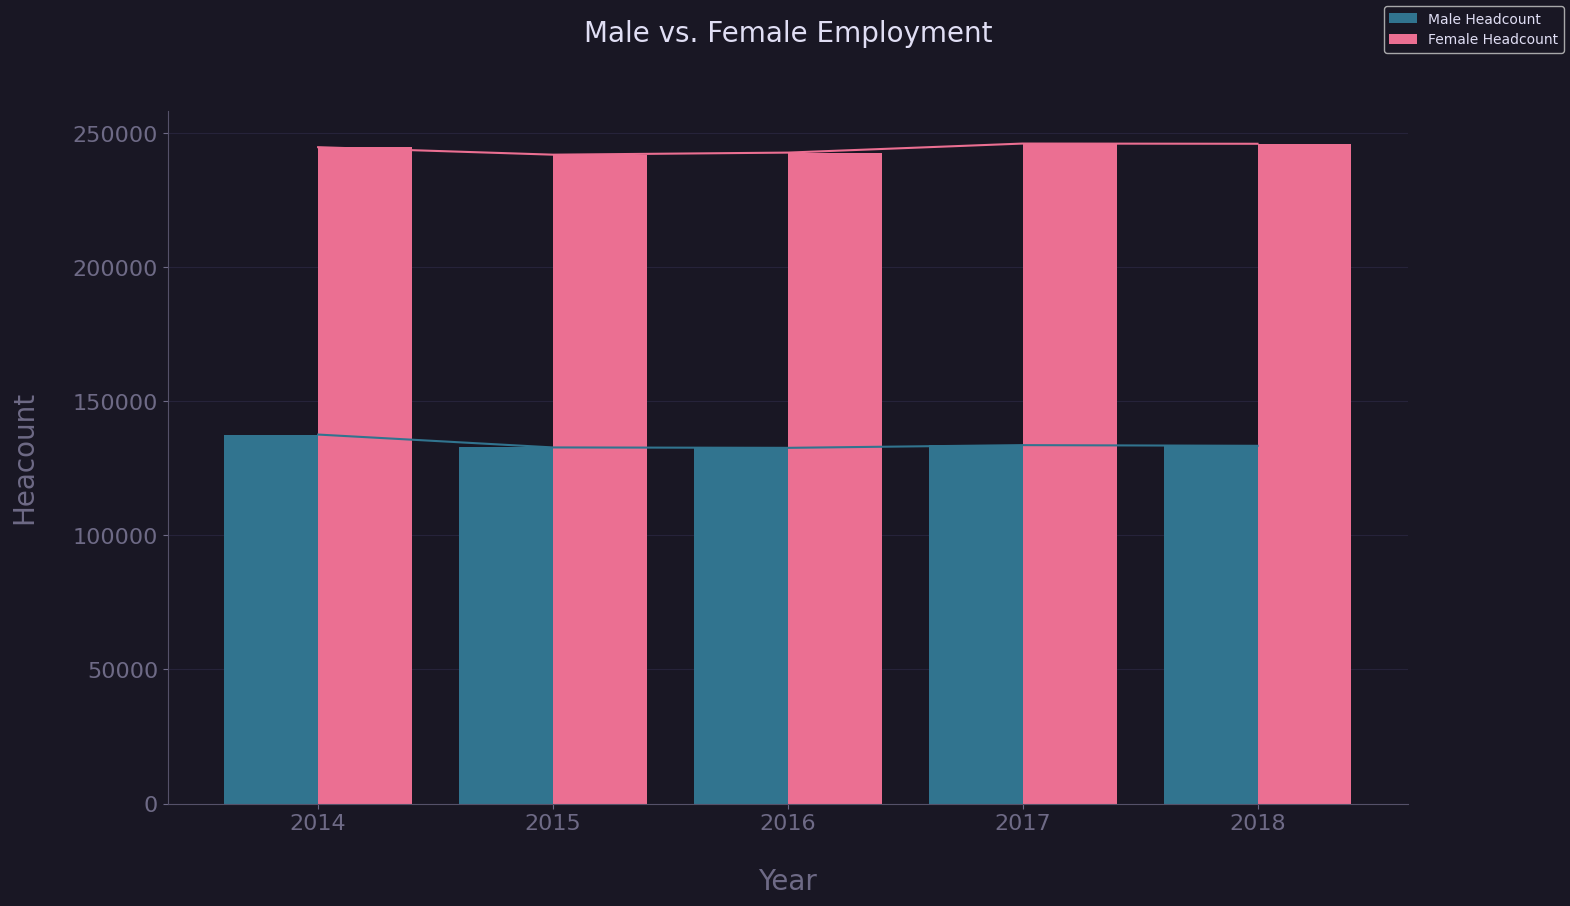

In [10]:
plot_sector_gender_bar(df, save_fig=True, transparent=False)

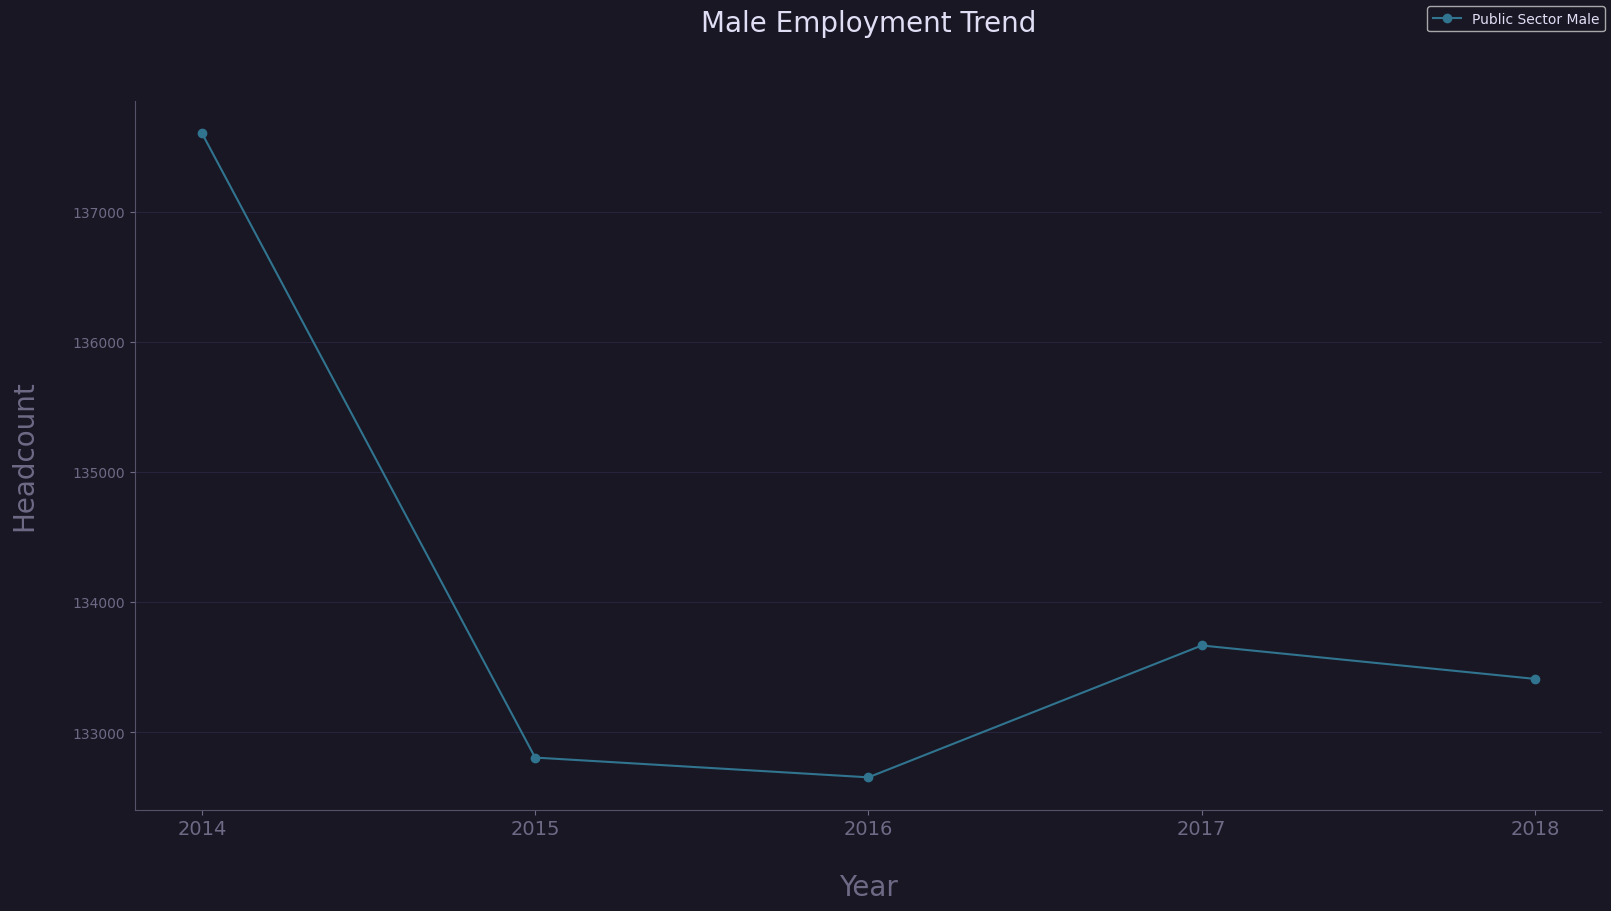

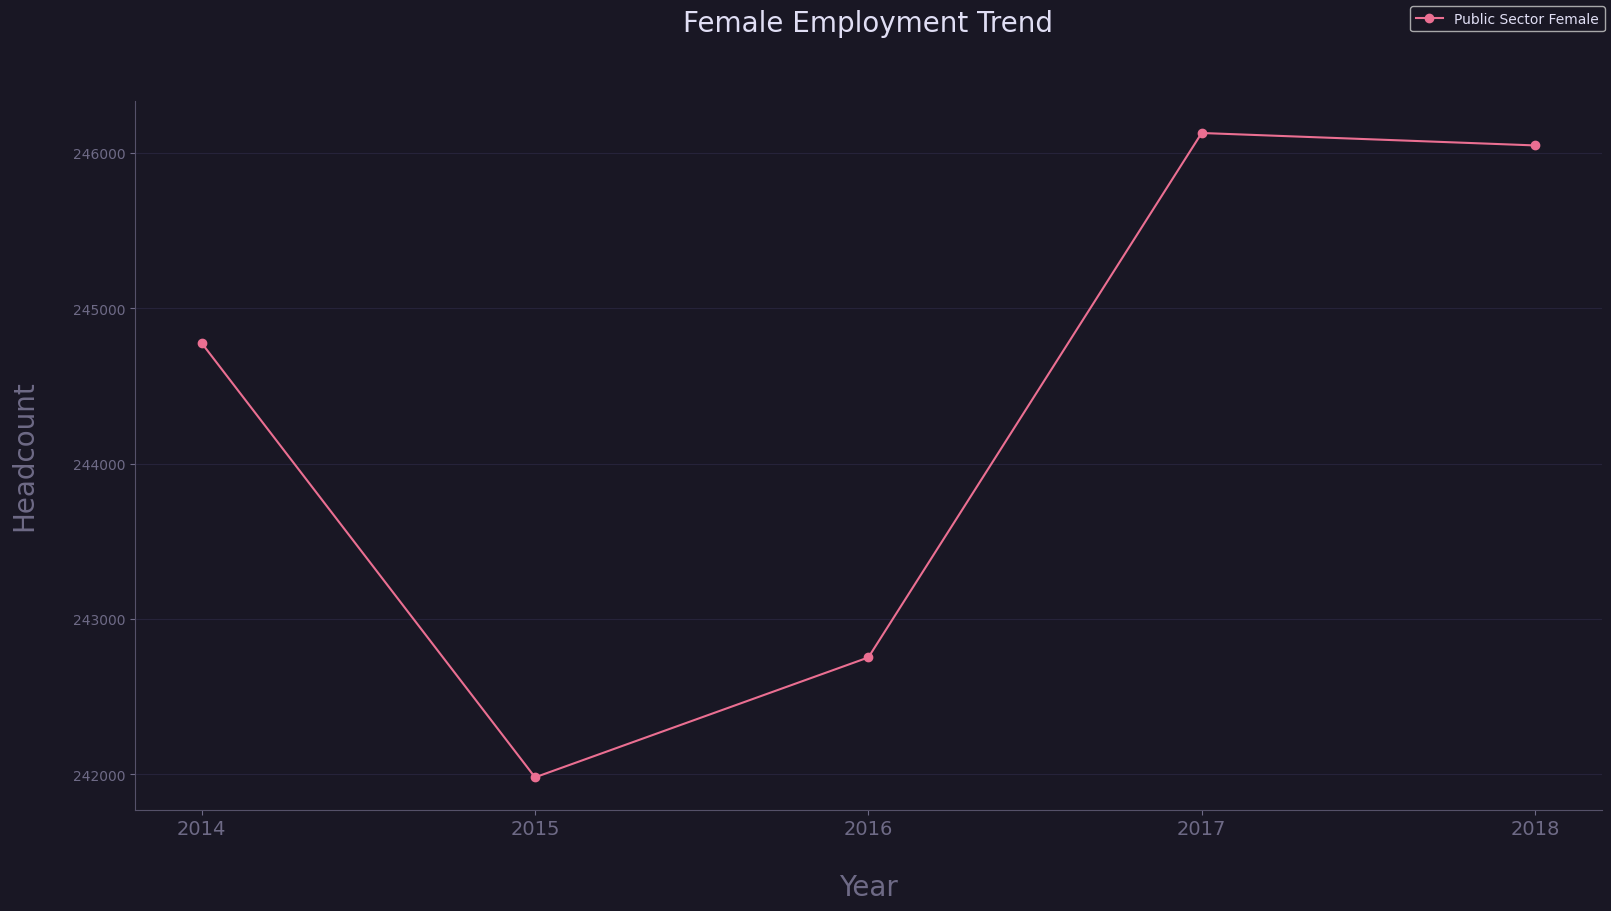

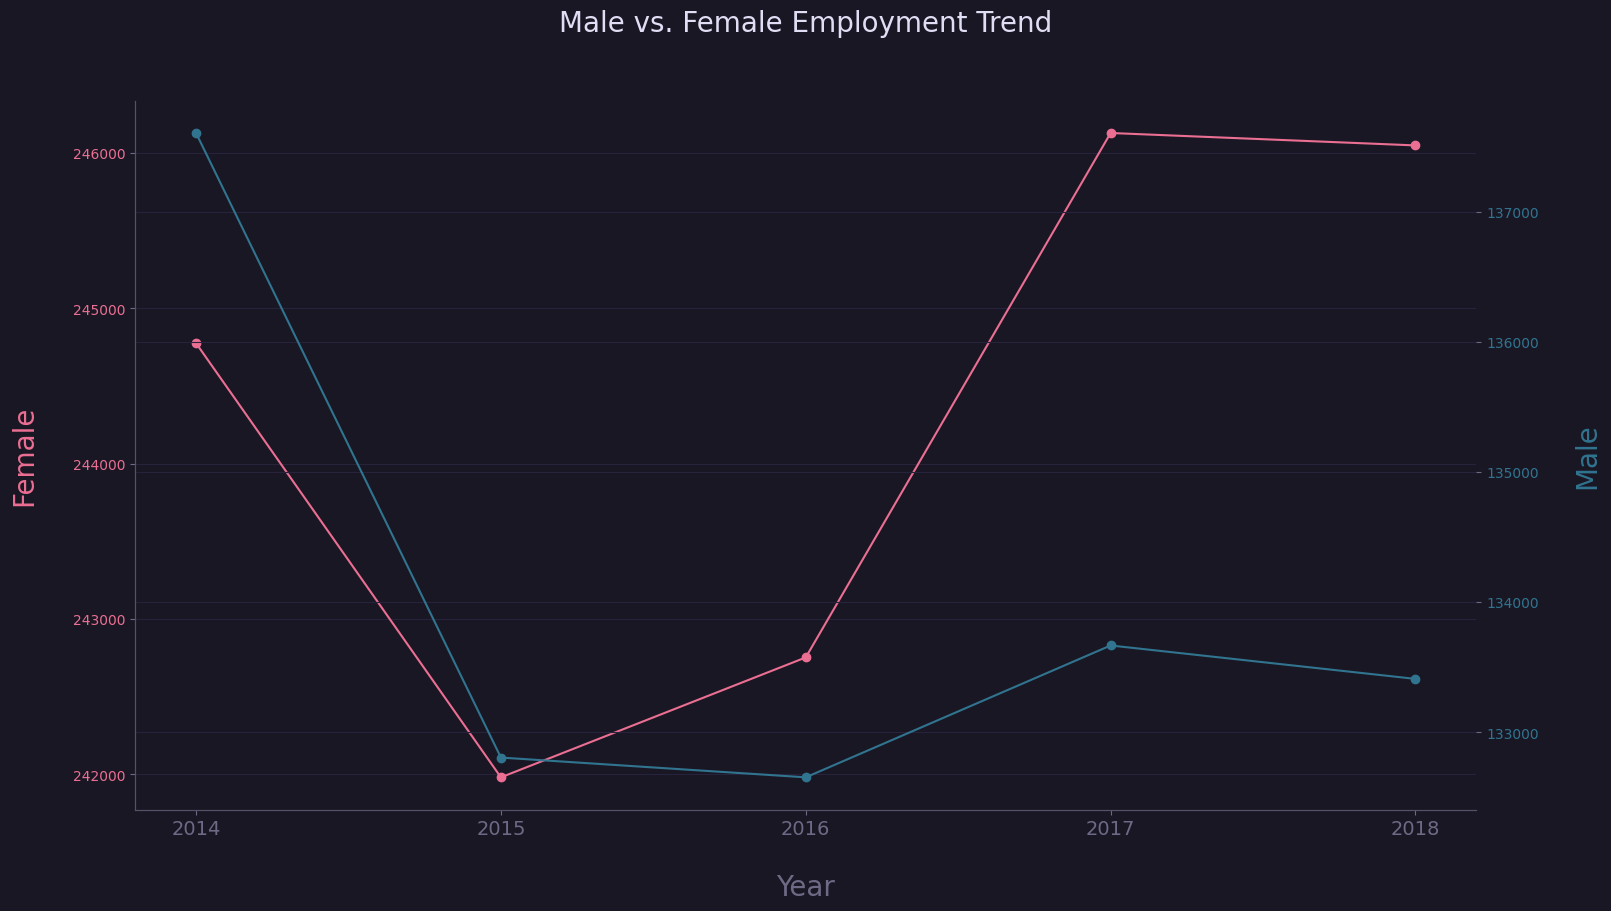

In [11]:
stats = statistics(df)
stats = transpose(stats)
stats['Year'] = np.array(df['Year'].unique())
stats.set_index('Year', inplace=True)

plot_stats(stats, {'Public Sector':['M']}, title='Male Employment Trend', double_scale=False, show=True, save_fig=True, transparent=False)
plot_stats(stats, {'Public Sector':['F']}, title='Female Employment Trend', double_scale=False, show=True, save_fig=True, transparent=False)
plot_stats(stats, {'Public Sector':['M', 'F']}, title='Male vs. Female Employment Trend', double_scale=True, show=True, save_fig=True, transparent=False)

#### 2. The current representation of part time employees in the sector and in each Cluster

Total Employee Headcount:	 379460 
Part-Time Employee Headcount:	 112250 
Full-Time Employee Headcount:	 267210


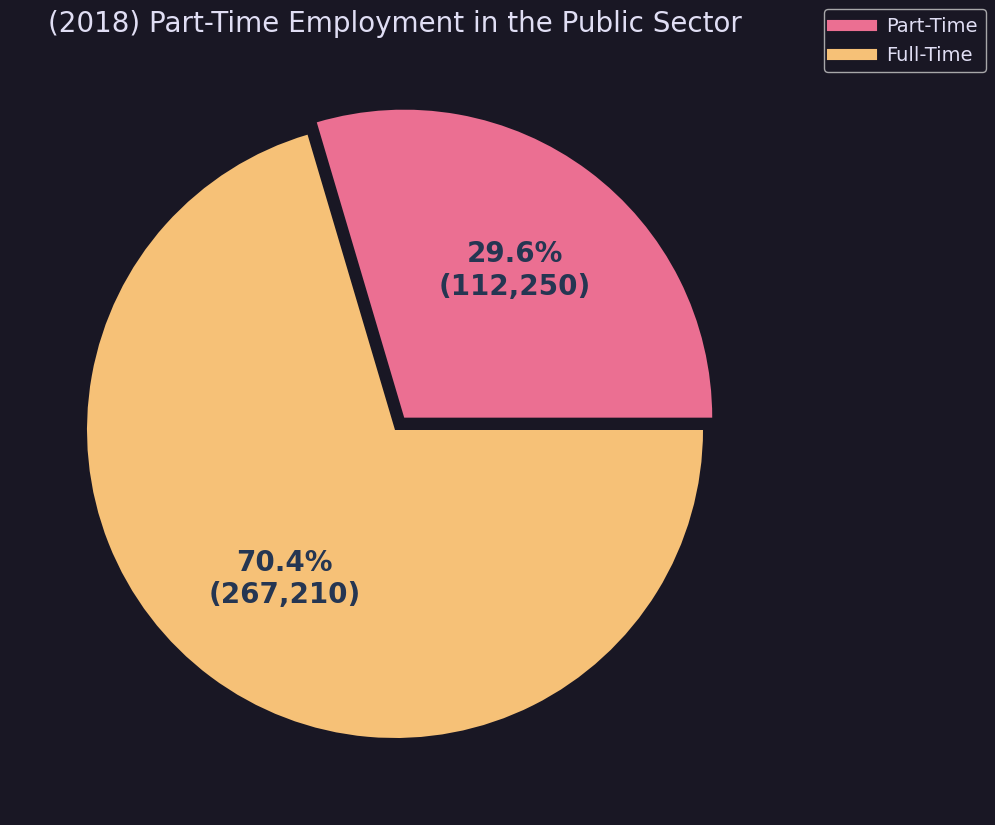

In [12]:
# Data includes dates up to year 2018, which must be the current date for this analysis.
# Split data into part-time and full-time employees of 2018
dfx = workforce_total(df, 2018)
df_pt, df_ft = dfx['pt'], dfx['ft']

hc = df_pt['Headcount'].sum() + df_ft['Headcount'].sum()
hc_pt = df_pt['Headcount'].sum()
hc_ft = df_ft['Headcount'].sum()

print('Total Employee Headcount:\t', hc,\
      '\nPart-Time Employee Headcount:\t', hc_pt,\
      '\nFull-Time Employee Headcount:\t', hc_ft)


# Plot total part-time employment in the public sector
# Ms. Pac-Man :)
plot_sector(df, 2018, figsize=(12, 8), save_fig=True, transparent=False)

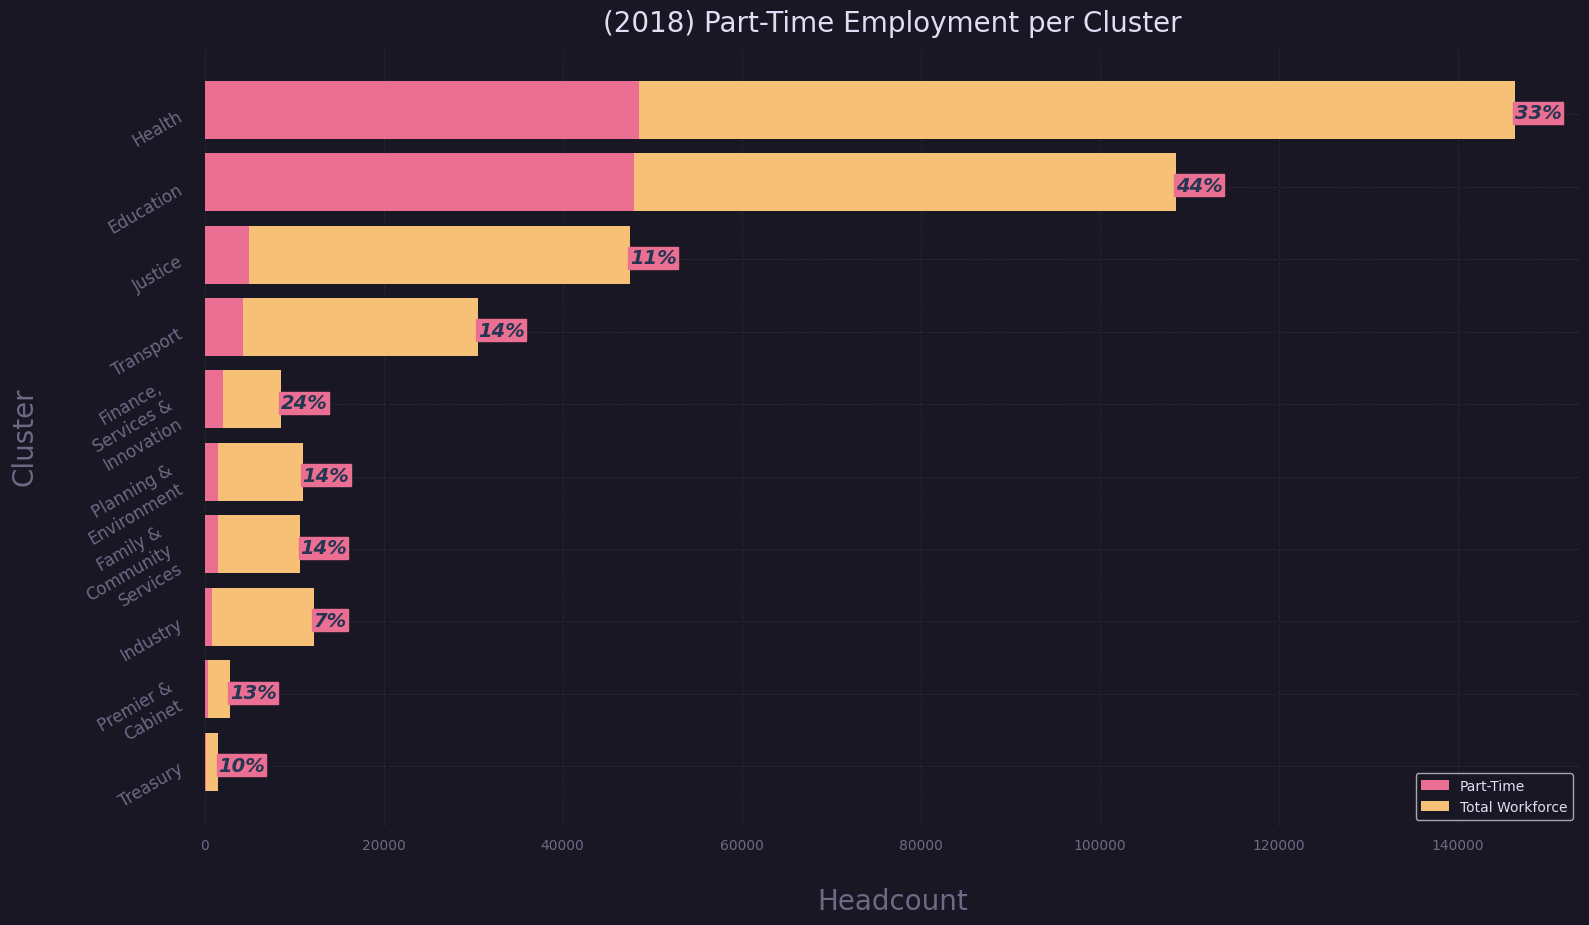

In [13]:
# Current Part-Time Employent per Cluster
#plot_cluster(df, year=2018, save_fig=True, transparent=True)
from custom_modules.plots import plot_cluster
plot_cluster(df, year=2018, h=True, save_fig=True, transparent=False)

#### 3. The current representation of male and female part time employees as a proportion of the respective male and the female workforce in the sector and in each cluster

Part-Time Male:		 22034 
Full-Time Male:		 111377 
Part-Time Female:	 90216 
Full-Time Female:	 155833


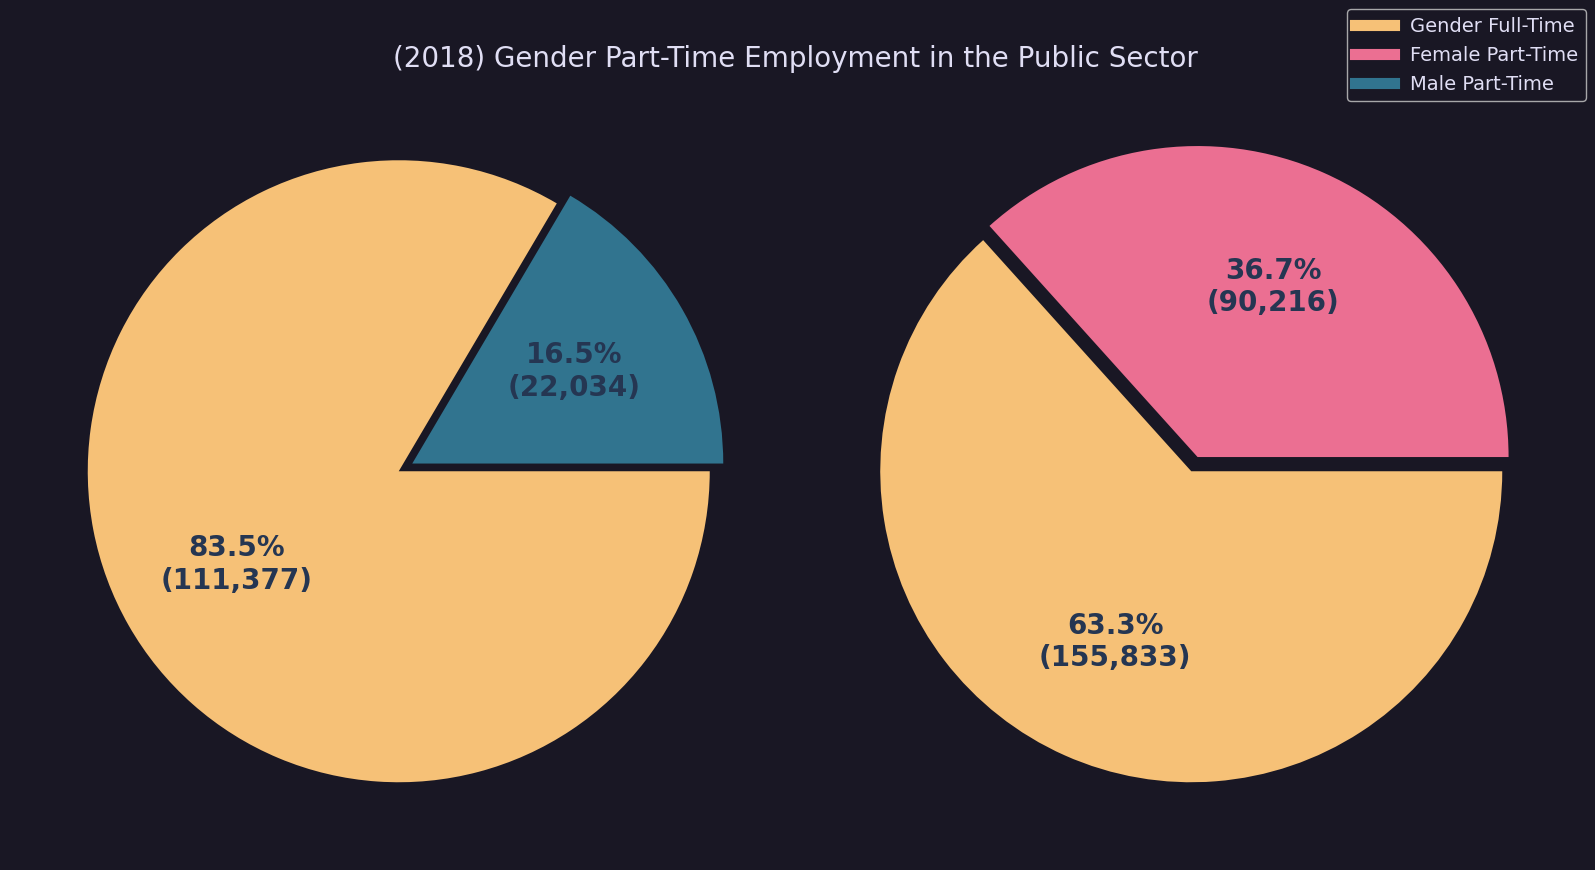

In [14]:
# split data into male part-time and female part-time
dfx = workforce_gender(df, 2018)
df_pt_female, df_ft_female, df_pt_male, df_ft_male = dfx['pt_f'], dfx['ft_f'], dfx['pt_m'], dfx['ft_m']
hc_pt_male = df_pt_male['Headcount'].sum()
hc_ft_male = df_ft_male['Headcount'].sum()
hc_pt_female = df_pt_female['Headcount'].sum()
hc_ft_female = df_ft_female['Headcount'].sum()

print('Part-Time Male:\t\t', hc_pt_male,\
      '\nFull-Time Male:\t\t', hc_ft_male,\
      '\nPart-Time Female:\t', hc_pt_female,\
      '\nFull-Time Female:\t', hc_ft_female)


# Plot male and female part-time employment in the Public Sector
plot_sector_gender(df, year=2018, save_fig=True, transparent=False)

In [15]:
# Group by cluster and show part-time and full-time representation for both genders
dfx = workforce_gender(df, year=2018)
df_all_cluster = dfx['cluster']
print(df_all_cluster.to_markdown())

|    | Cluster                        |   PT/F |   FT/F |      F |   PT/M |   FT/M |     M |
|---:|:-------------------------------|-------:|-------:|-------:|-------:|-------:|------:|
|  0 | Education                      |  39156 |  44447 |  83603 |   8783 |  16068 | 24851 |
|  1 | Family & Community Services    |   1399 |   6868 |   8267 |    113 |   2296 |  2409 |
|  2 | Finance, Services & Innovation |   1368 |   3694 |   5062 |    690 |   2766 |  3456 |
|  3 | Health                         |  41002 |  67660 | 108662 |   7498 |  30152 | 37650 |
|  4 | Industry                       |    699 |   5739 |   6438 |    114 |   5650 |  5764 |
|  5 | Justice                        |   3574 |  15401 |  18975 |   1447 |  27076 | 28523 |
|  6 | Planning & Environment         |   1251 |   3814 |   5065 |    302 |   5580 |  5882 |
|  7 | Premier & Cabinet              |    292 |   1386 |   1678 |     71 |   1061 |  1132 |
|  8 | Transport                      |   1345 |   6037 |   7382 |   2

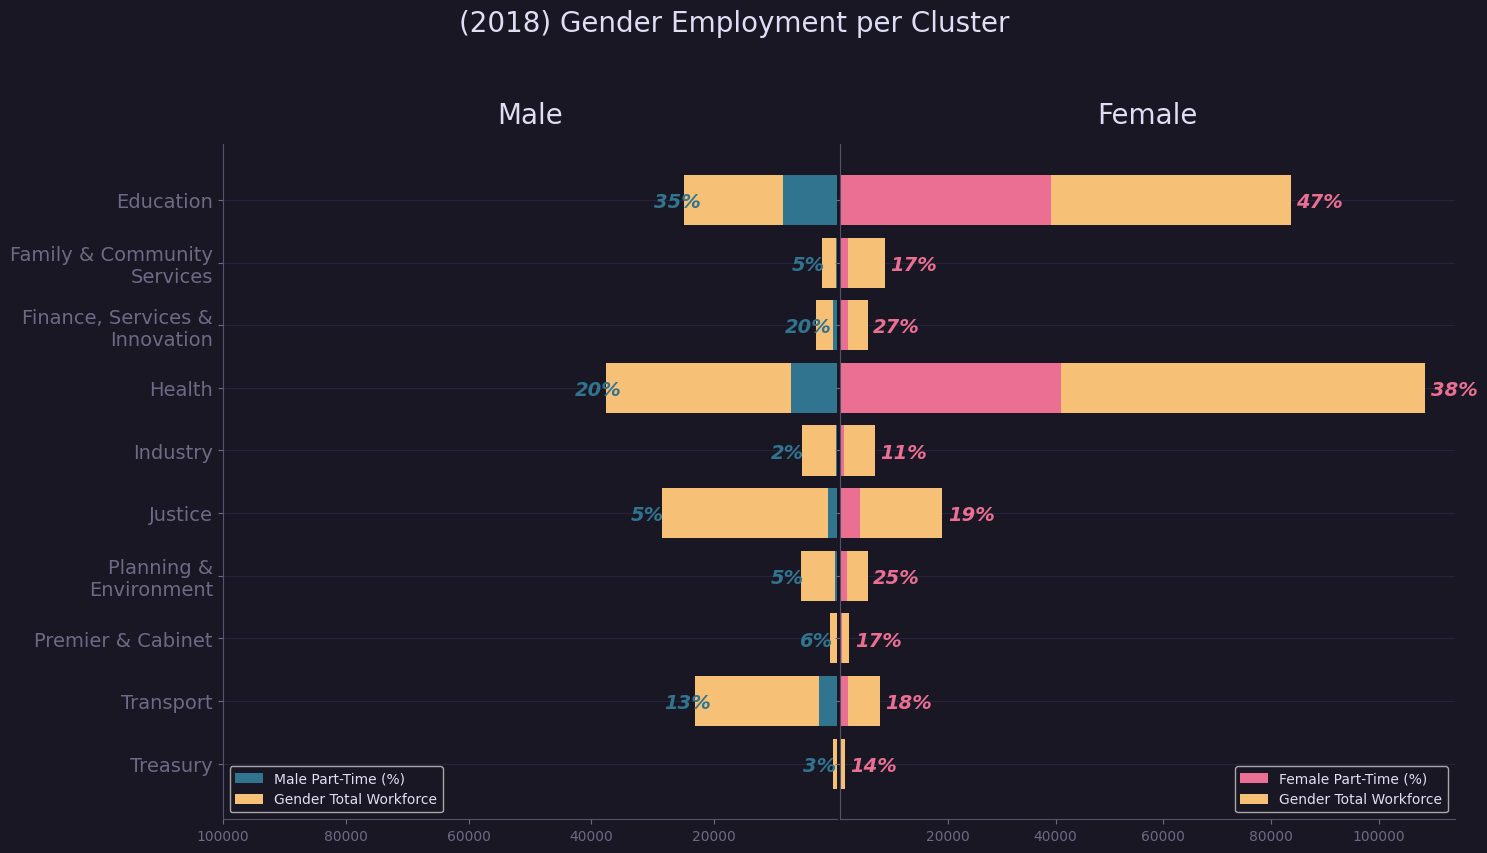

In [16]:
# Plot male and female part-time employment per Cluster
plot_cluster_gender(df, year=2018, save_fig=True, transparent=False)

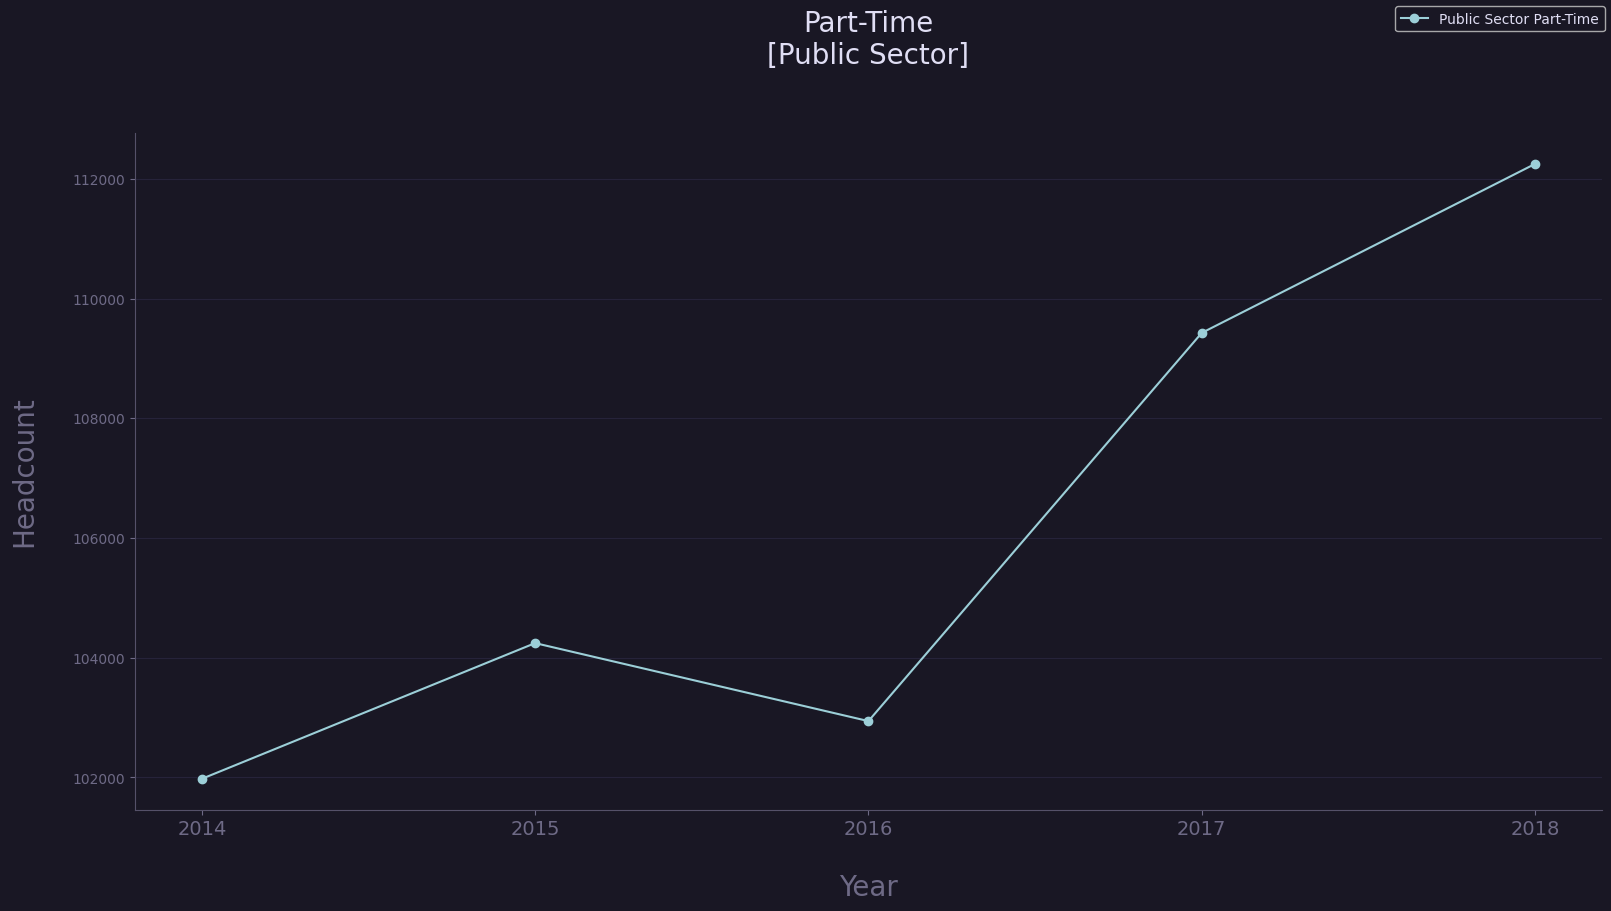

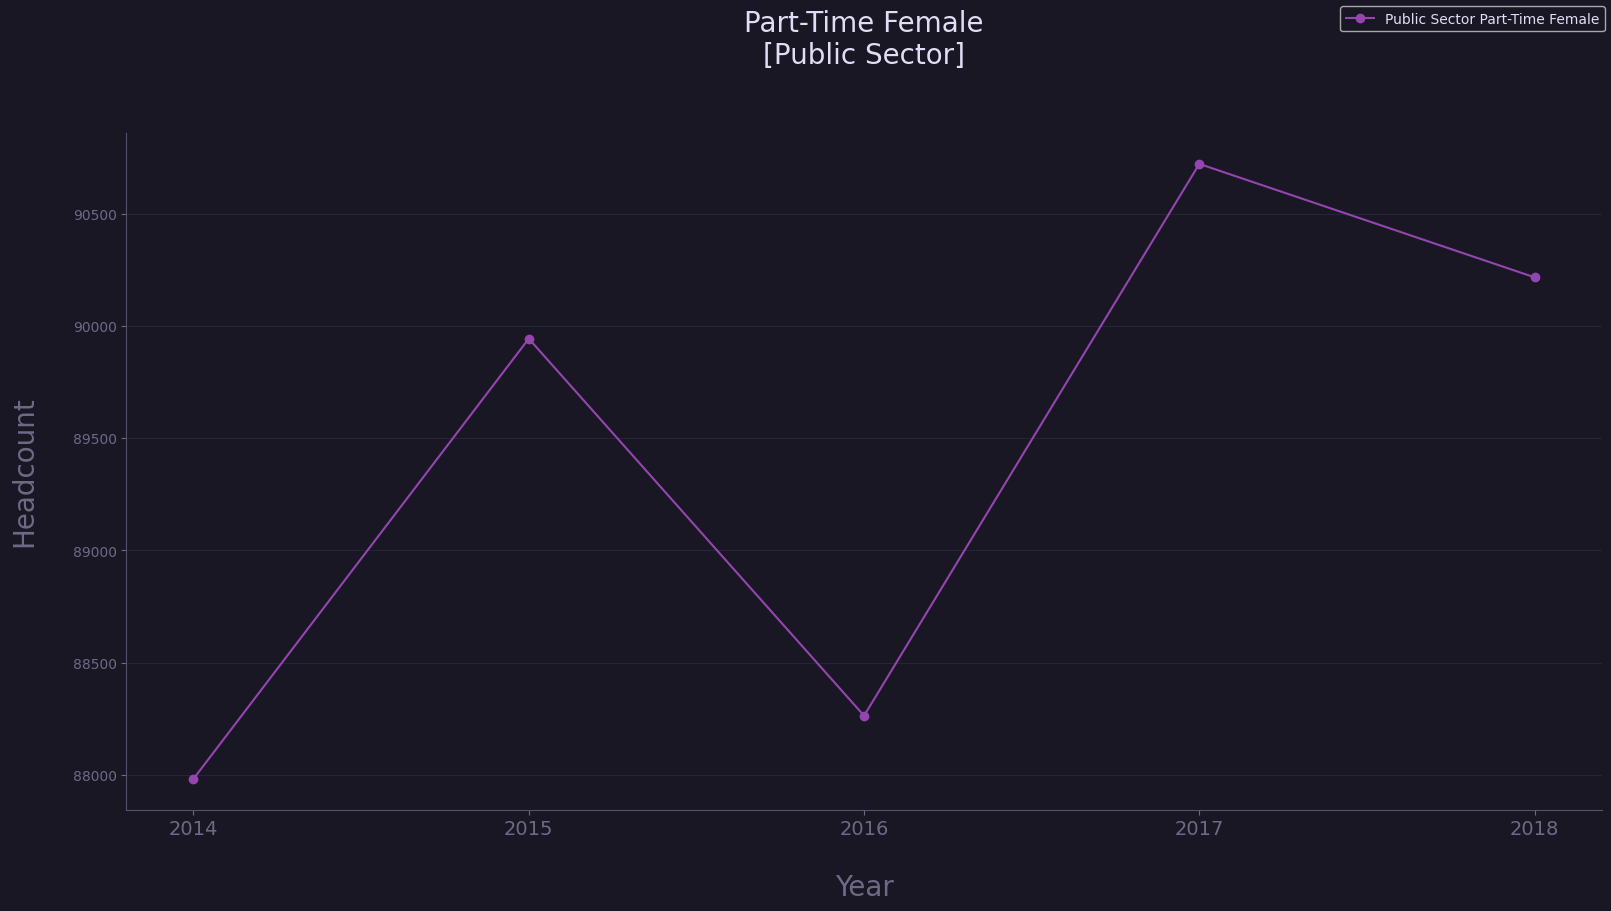

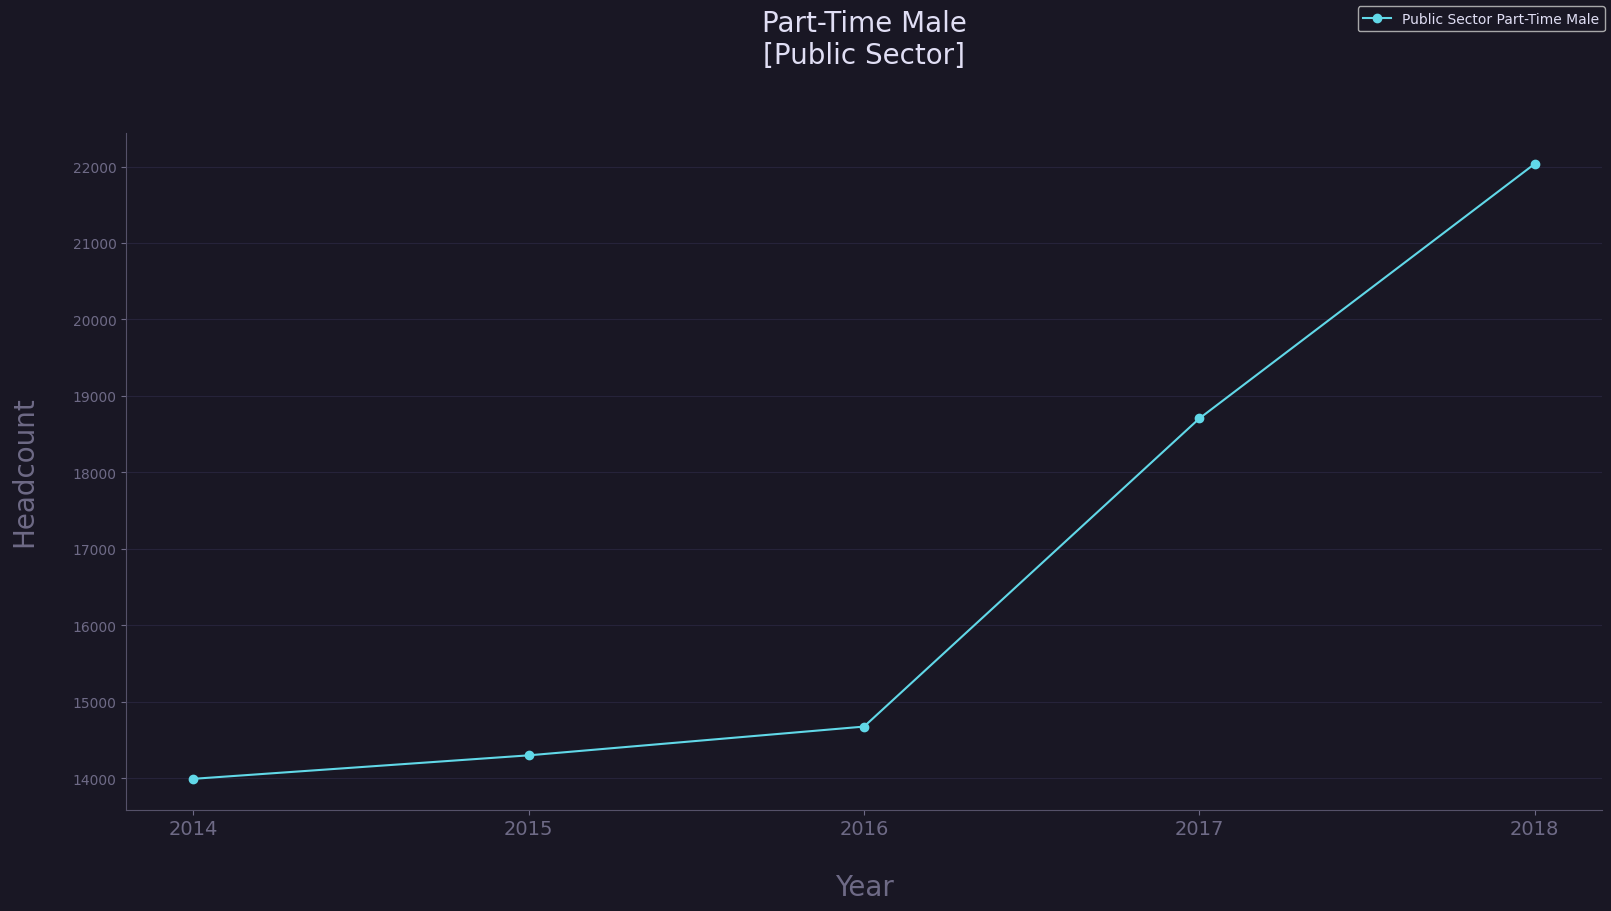

In [17]:
plot_stats(stats, {'Public Sector':['PT']}, title='auto', show=True, save_fig=True)
plot_stats(stats, {'Public Sector':['PT/F']}, title='auto', show=True, save_fig=True)
plot_stats(stats, {'Public Sector':['PT/M']}, title='auto', show=True, save_fig=True)

#### 4. Change in these two above statistics over the last 4 years

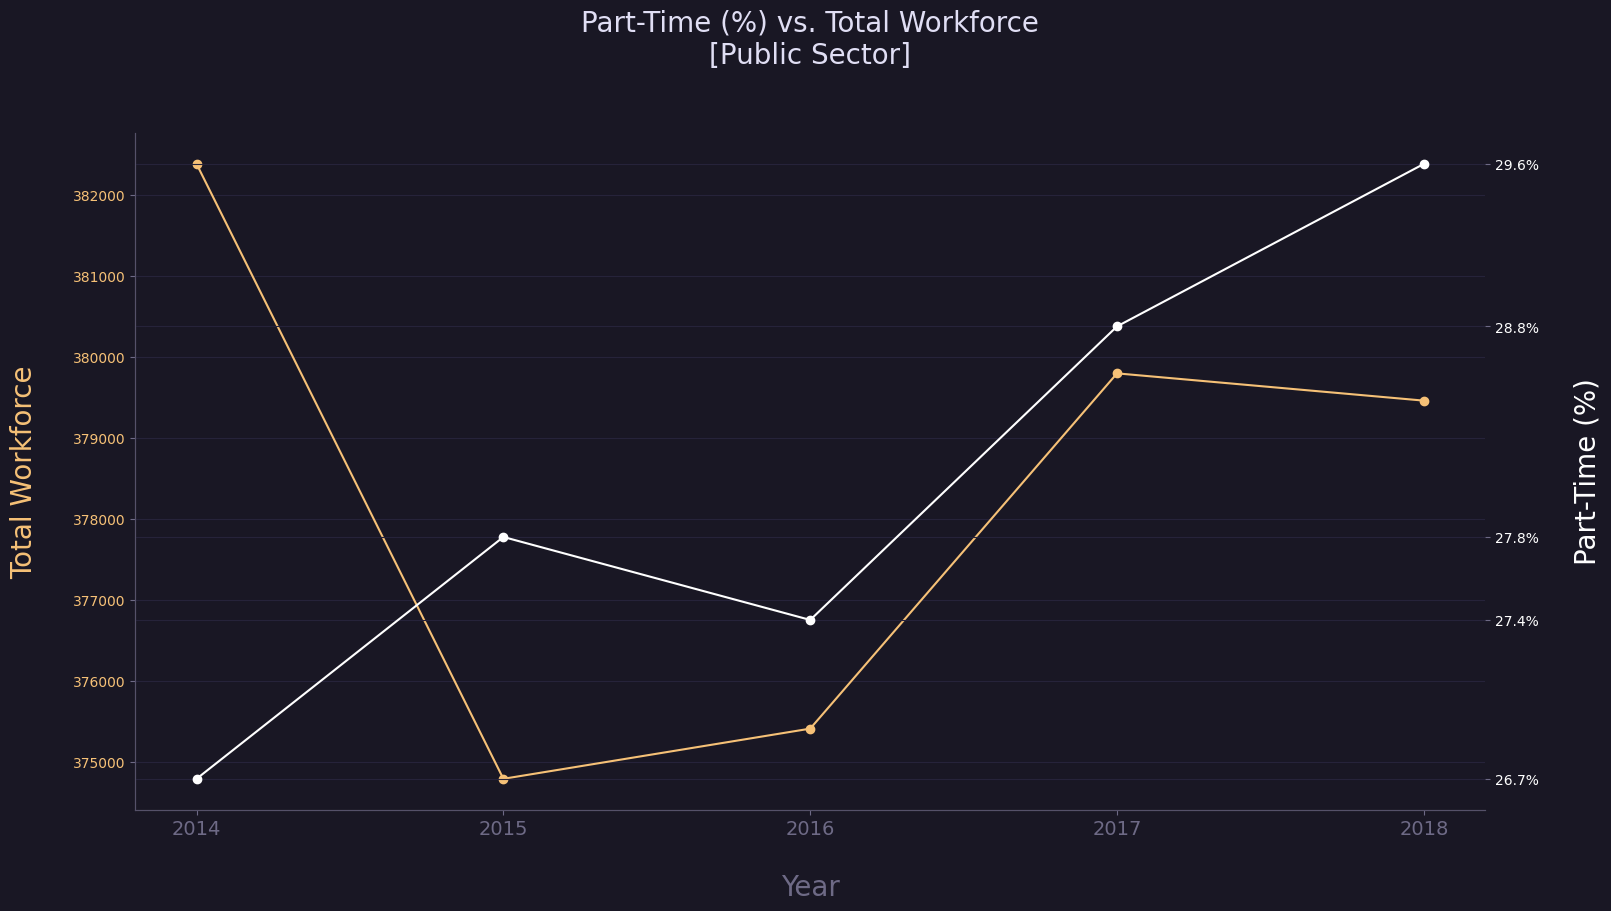

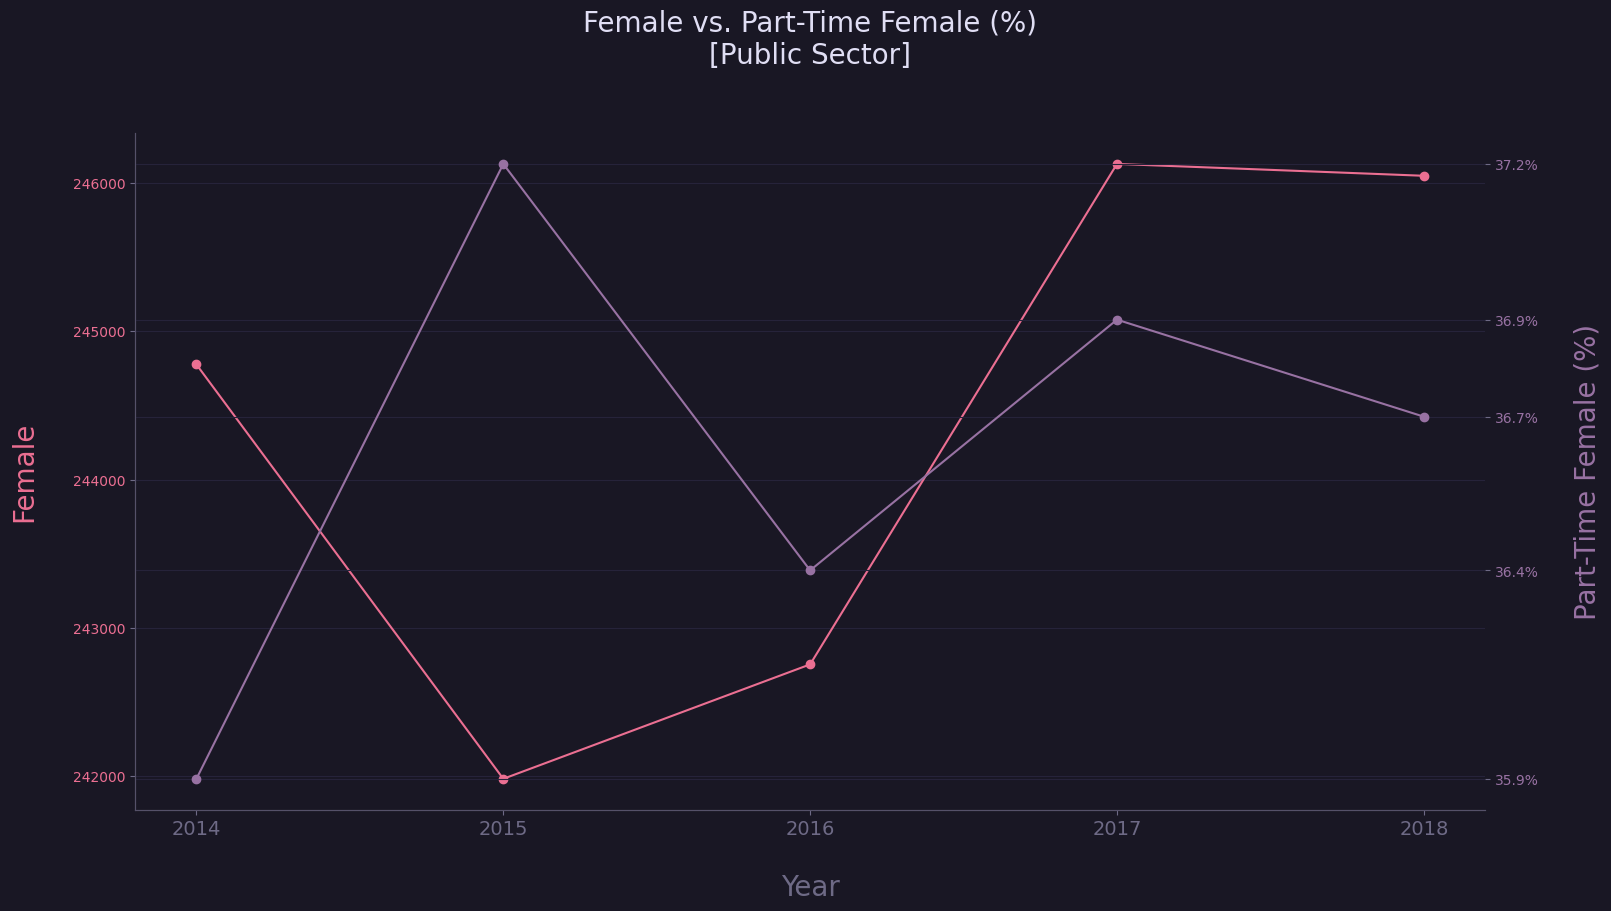

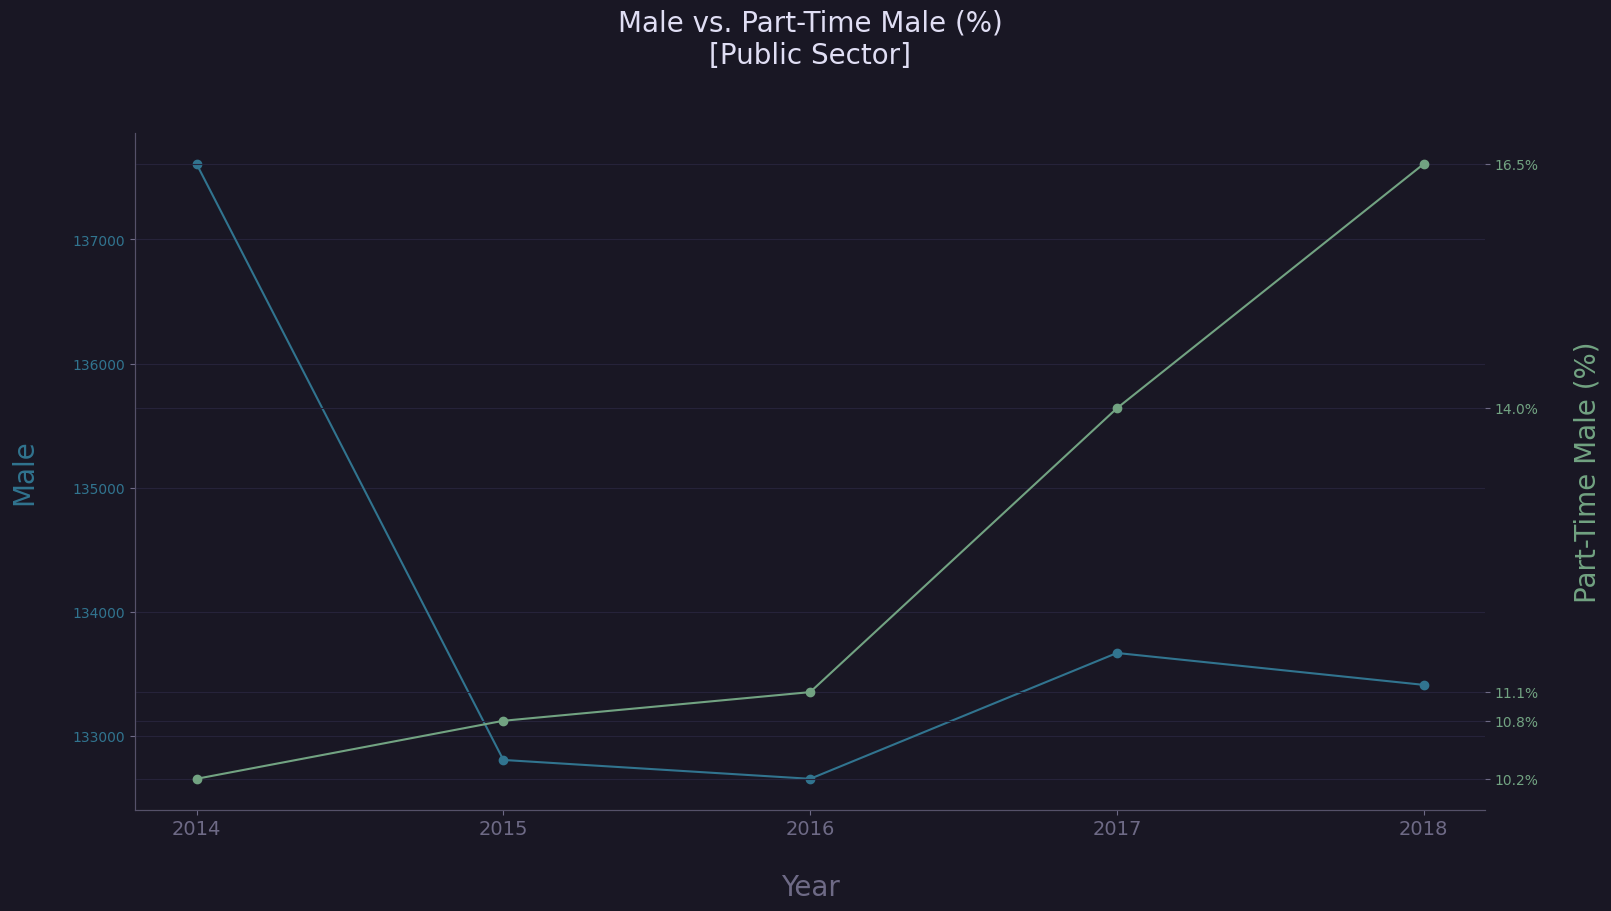

In [18]:
# All plots are saved. Showing only "Public Sector" here.
for cat in CAT:
    if cat == 'Public Sector':
        plot_stats(stats, {cat:['WF', 'PT/Ratio']}, title='auto', double_scale=True, show=(cat=='Public Sector'), save_fig=True, transparent=False)
        plot_stats(stats, {cat:['F', 'PT/F/Ratio']}, title='auto', double_scale=True, show=(cat=='Public Sector'), save_fig=True, transparent=False)
        plot_stats(stats, {cat:['M', 'PT/M/Ratio']}, title='auto', double_scale=True, show=(cat=='Public Sector'), save_fig=True, transparent=False)

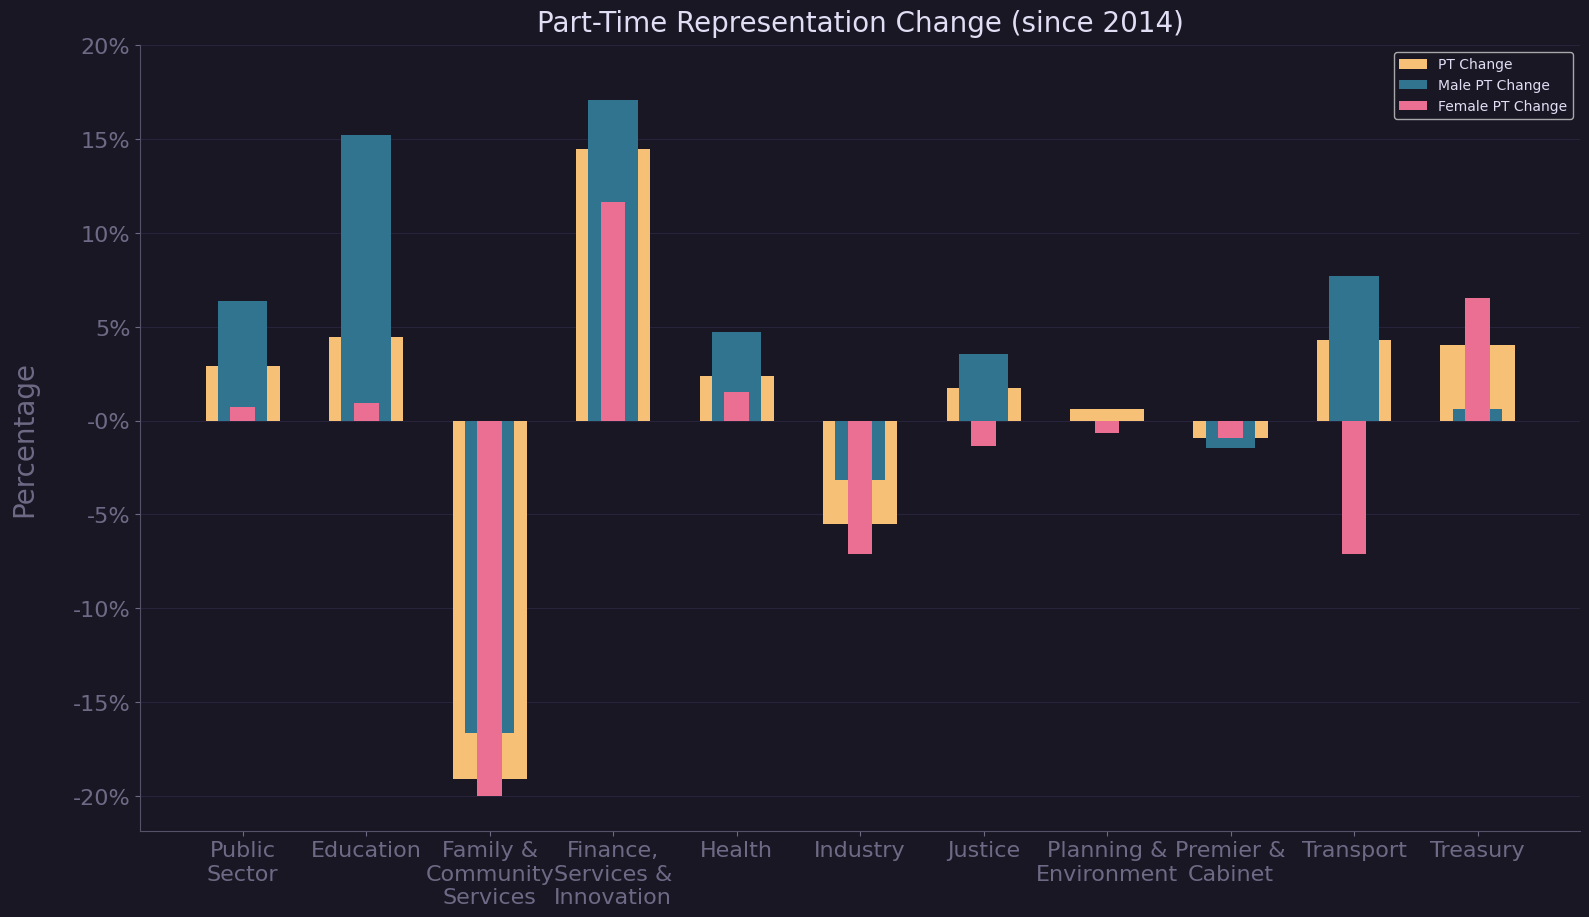

In [19]:
# Plot male and female part-time representation change
plot_change(df, save_fig=True, transparent=False)

#### 5. Projection of what the representation will be by 2025 if the current trends continue

In [20]:
stats = statistics(df)
stats = transpose(stats)
stats['Year'] = np.array(df['Year'].unique())
stats.set_index('Year', inplace=True)
print(stats.to_markdown())

|   Year |   Public Sector/PT |   Public Sector/FT |   Public Sector/WF |   Public Sector/PT/Ratio |   Public Sector/PT/F |   Public Sector/PT/F/Ratio |   Public Sector/FT/F |   Public Sector/F |   Public Sector/PT/M |   Public Sector/PT/M/Ratio |   Public Sector/FT/M |   Public Sector/M |   Education/PT |   Education/FT |   Education/WF |   Education/PT/Ratio |   Education/PT/F |   Education/PT/F/Ratio |   Education/FT/F |   Education/F |   Education/PT/M |   Education/PT/M/Ratio |   Education/FT/M |   Education/M |   Family & Community Services/PT |   Family & Community Services/FT |   Family & Community Services/WF |   Family & Community Services/PT/Ratio |   Family & Community Services/PT/F |   Family & Community Services/PT/F/Ratio |   Family & Community Services/FT/F |   Family & Community Services/F |   Family & Community Services/PT/M |   Family & Community Services/PT/M/Ratio |   Family & Community Services/FT/M |   Family & Community Services/M |   Finance, Services & Innovat

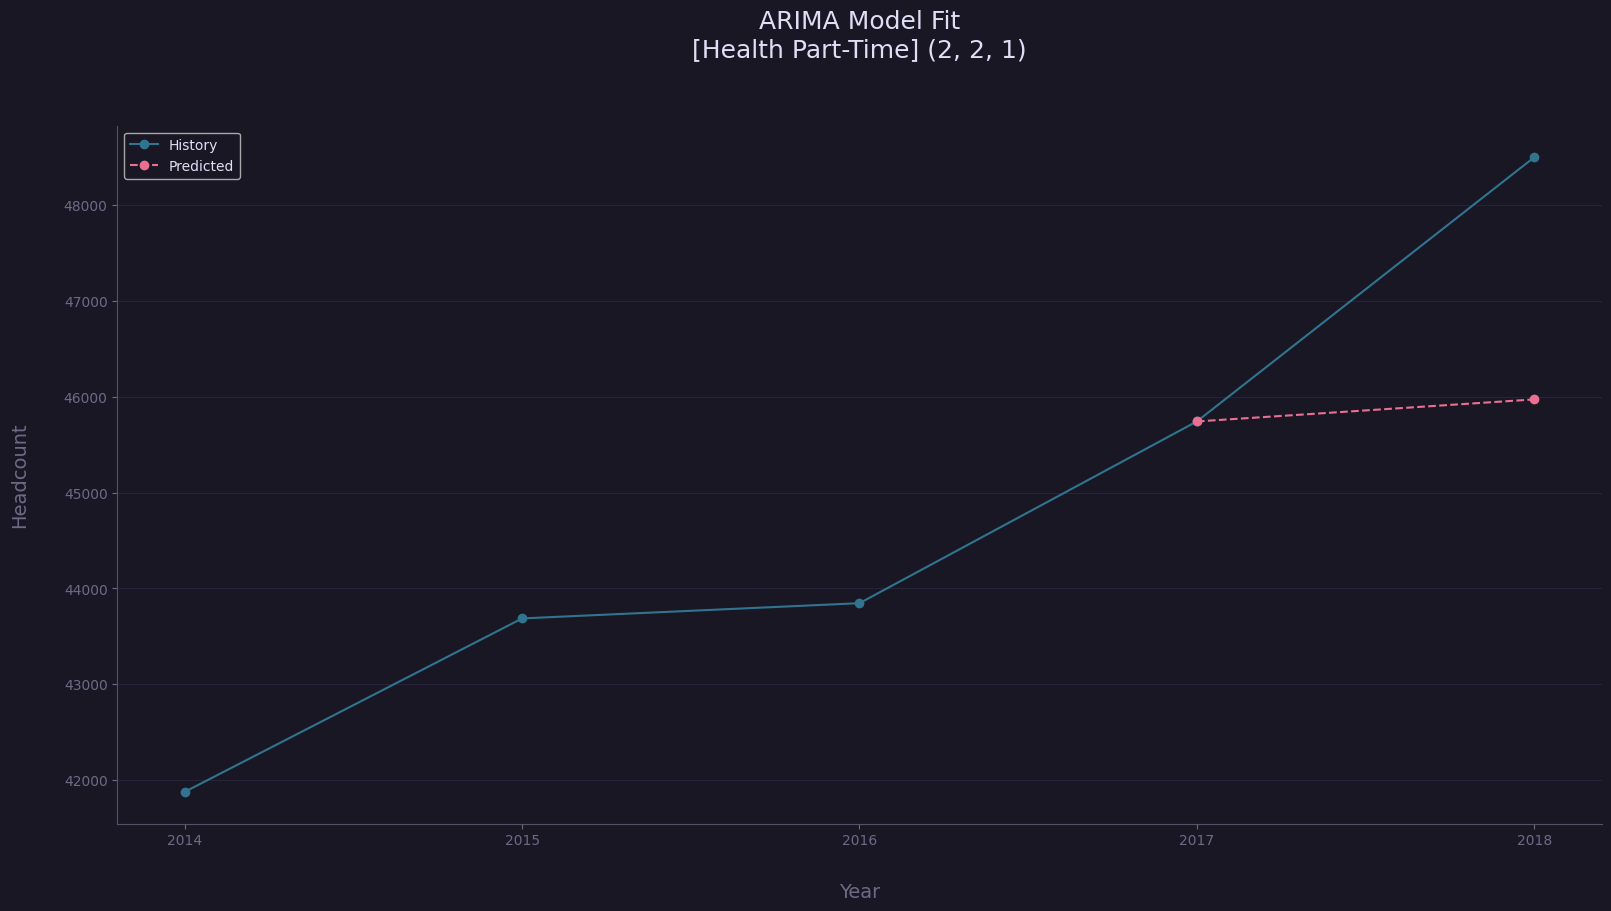

In [21]:
# Evaluate an ARIMA model with arbitrary parameters
'''
NOTE
We are making the predictions on log scaled values.
The reason is to prevent negative predictions when the model is forecasting a downtrend.
After making a prediction, we scale back to level with numpy exponent function.
i.e. This will prevent Headcount from going below zero, and at the same time suppress unreasonably high values.
'''

title = 'Health ' + STAT['PT']
col = 'Health/PT'
error = evaluate(stats[col], arima_order=(2,2,1), train_size=0.8, log=True, title=title, show=True, transparent=False)

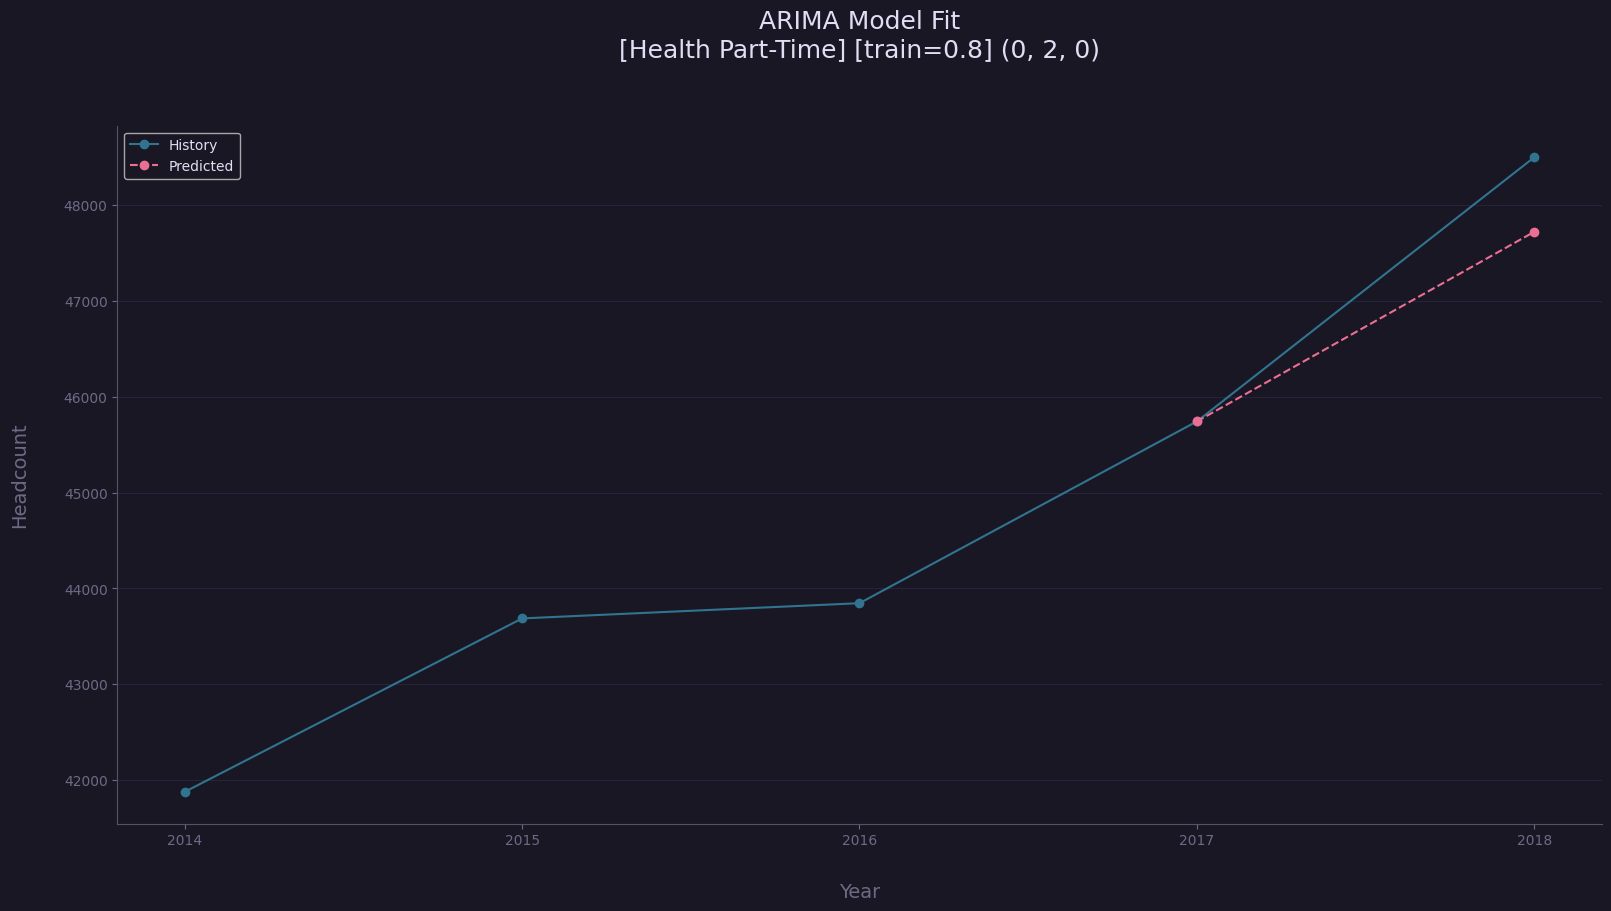

In [22]:
# Grid Search for optimal or near optimal parameters
p, d, q = range(0, 5), range(0, 3), range(0, 3)
cfg = grid_search(stats[col], p, d, q, train_size=0.8, log=True, title=title, show=True)

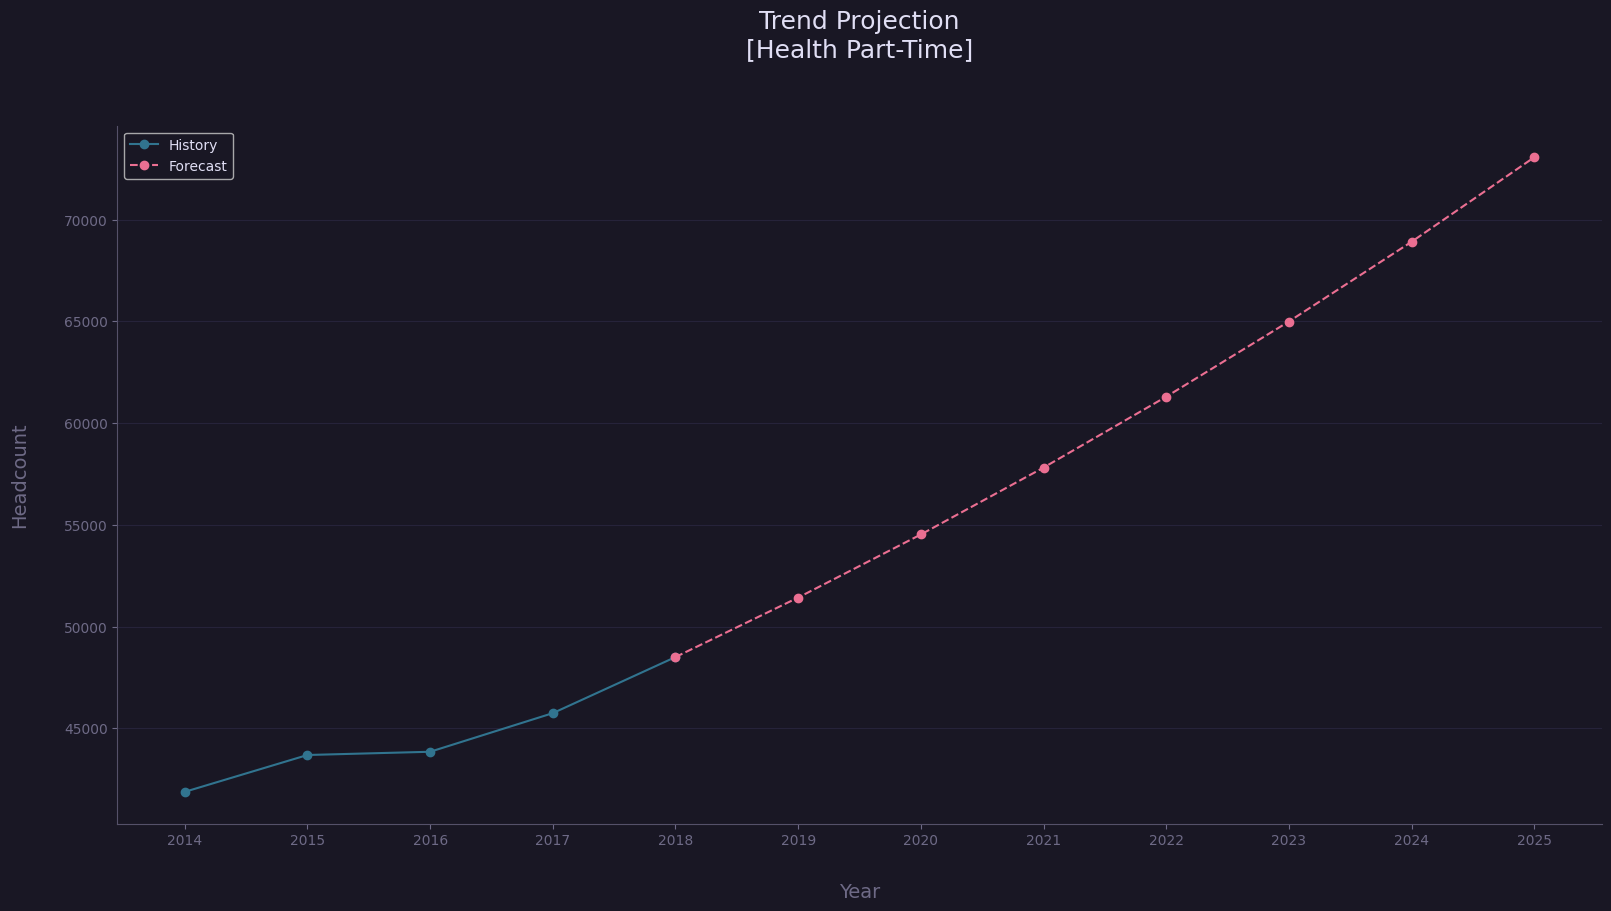

In [23]:
# Trend Projection
pred = projection(stats[col], arima_order=cfg, years=7, log=True, title=title, show=True, transparent=False)

In [24]:
# This will take a long time if re-generating forecasts.
if os.path.isfile('forecast-direct.json'):
    with open('forecast-direct.json') as f:
        fc = json.load(f)

else:
    atomic_stats = ['PT/M', 'FT/M', 'PT/F', 'FT/F']
    fc = defaultdict(lambda: defaultdict(list))
    for cat in CAT:
        for stat in atomic_stats:
            title = cat + ' ' + STAT[stat]
            col = cat + '/' + stat
            dataset = stats[col]
            p_values = range(0, 6)
            d_values = range(0, 5)
            q_values = range(0, 5)
            cfg = grid_search(dataset, p_values, d_values, q_values, log=True, title=title, save_fig=True, transparent=False)
            pred = projection(dataset, cfg, years=7, log=True, title=title, save_fig=True, transparent=False)
            print(title, cfg)
            fc[cat][stat] = pred

    for k in fc: # :)
        fc[k]['PT'] = [sum(x) for x in zip(fc[k]['PT/M'], fc[k]['PT/F'])]
        fc[k]['FT'] = [sum(x) for x in zip(fc[k]['FT/M'], fc[k]['FT/F'])]
        fc[k]['F'] = [sum(x) for x in zip(fc[k]['PT/F'], fc[k]['FT/F'])]
        fc[k]['M'] = [sum(x) for x in zip(fc[k]['PT/M'], fc[k]['FT/M'])]
        fc[k]['WF'] = [sum(x) for x in zip(fc[k]['F'], fc[k]['M'])]
        fc[k]['PT/Ratio'] = [i / j for i, j in zip(fc[k]['PT'], fc[k]['WF'])]
        fc[k]['PT/M/Ratio'] = [i / j for i, j in zip(fc[k]['PT/M'], fc[k]['M'])]
        fc[k]['PT/F/Ratio'] = [i / j for i, j in zip(fc[k]['PT/F'], fc[k]['F'])]
    
    with open("forecast-direct.json", "w") as f:
        json.dump(fc, f)

In [25]:
'''
*   Since the Public Sector is comprised of several clusters,
    each have their own different employment trends for both genders,
    it would be wise to take the aggregation of all cluster predictions
    to come up with the public sector forecast instead of directly applying the prediciton model on it.

*   This cell will show the difference between applying the model directly to the entire sector
    against taking into account the trend projections of the atomic variables PT/M, PT/F, FT/M, FT/F from each cluster.
    I believe this method gives a more granular and robust result.
'''

if os.path.isfile('forecast-direct.json'):
    with open('forecast-direct.json') as f:
        fc_direct = json.load(f)

if os.path.isfile('forecast-direct.json'):
    with open('forecast-direct.json') as f:
        fc_agg = json.load(f)

sec = defaultdict(list)
for k in fc_agg:
    if k == 'Public Sector':
        continue
    sec['PT/M'].append(fc_agg[k]['PT/M'])
    sec['PT/F'].append(fc_agg[k]['PT/F'])
    sec['FT/M'].append(fc_agg[k]['FT/M'])
    sec['FT/F'].append(fc_agg[k]['FT/F'])

for k in sec:
    sec[k] = [sum(x) for x in zip(*sec[k])]

sec['PT'] = [sum(x) for x in zip(sec['PT/M'], sec['PT/F'])]
sec['FT'] = [sum(x) for x in zip(sec['FT/M'], sec['FT/F'])]
sec['F'] = [sum(x) for x in zip(sec['PT/F'], sec['FT/F'])]
sec['M'] = [sum(x) for x in zip(sec['PT/M'], sec['FT/M'])]
sec['WF'] = [sum(x) for x in zip(sec['F'], sec['M'])]
sec['PT/Ratio'] = [i / j for i, j in zip(sec['PT'], sec['WF'])]
sec['PT/M/Ratio'] = [i / j for i, j in zip(sec['PT/M'], sec['M'])]
sec['PT/F/Ratio'] = [i / j for i, j in zip(sec['PT/F'], sec['F'])]

fc_agg['Public Sector'] = sec
with open("forecast-agg.json", "w") as f:
    json.dump(fc_agg, f)


history_years = stats.index.to_list()
last_year = history_years[-1]

fc_direct = transpose(fc_direct)
pred_years = list(range(last_year+1, last_year+len(fc_direct)+1))
fc_direct['Year'] = np.array(pred_years)
fc_direct.set_index('Year', inplace=True)

fc_agg = transpose(fc_agg)
fc_agg['Year'] = np.array(pred_years)
fc_agg.set_index('Year', inplace=True)

# for s in STAT:
#     plot_trend(stats, fc_direct, 'Public Sector', s, show=False, title=f'Public Sector {s} [1]-Before', save_fig=False, transparent=False)
#     plot_trend(stats, fc_agg, 'Public Sector', s, show=False, title=f'Public Sector {s} [2]-After', save_fig=False, transparent=False)


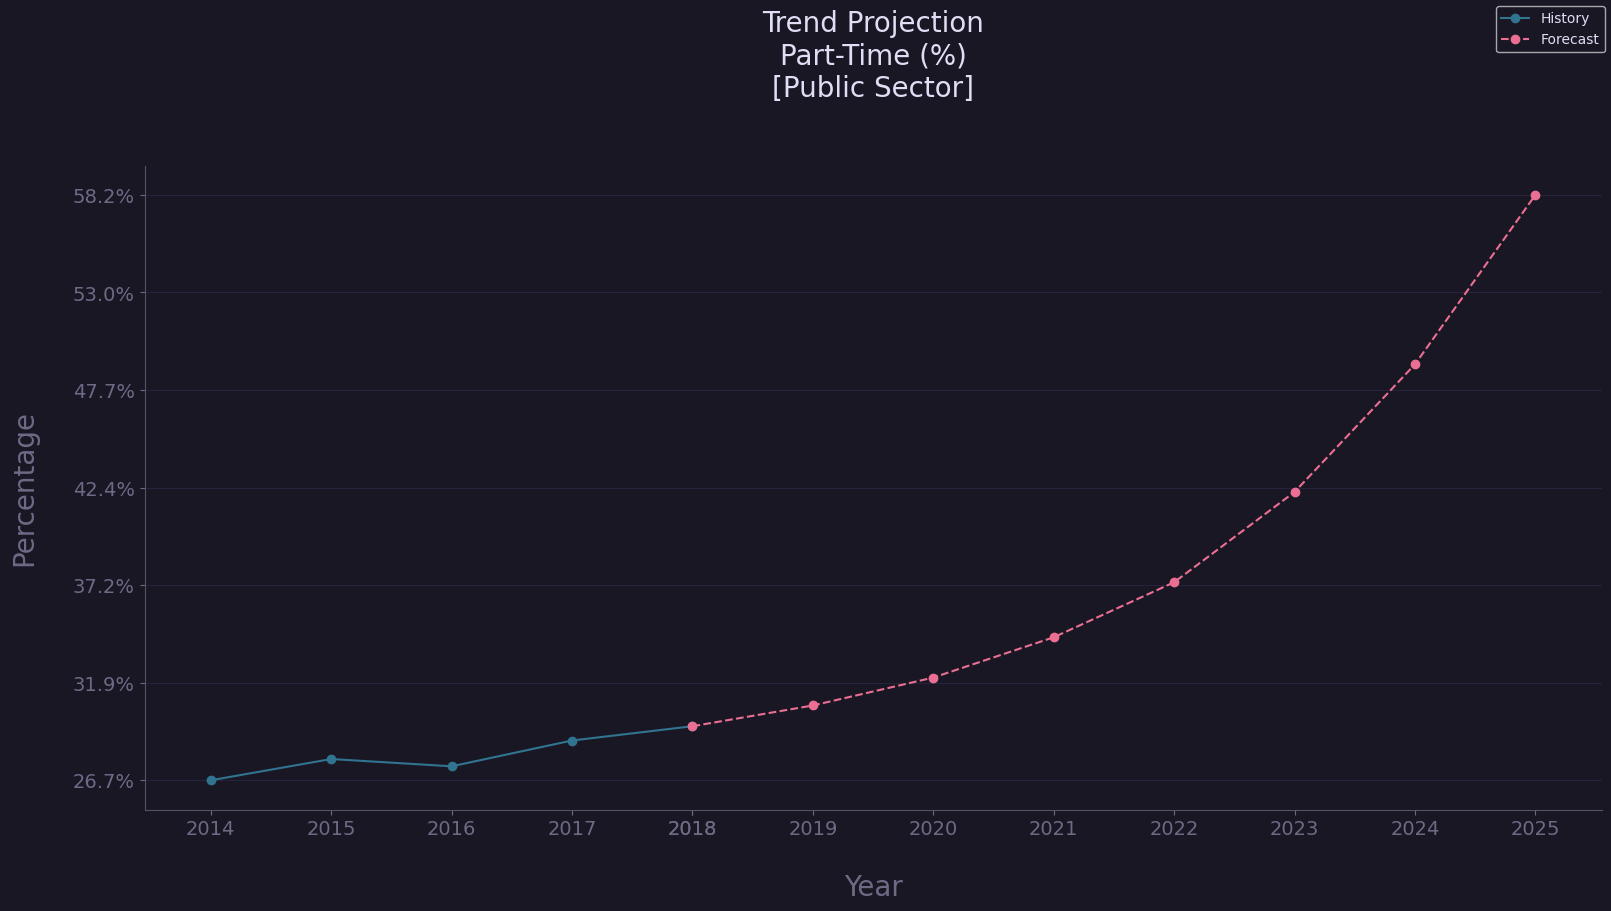

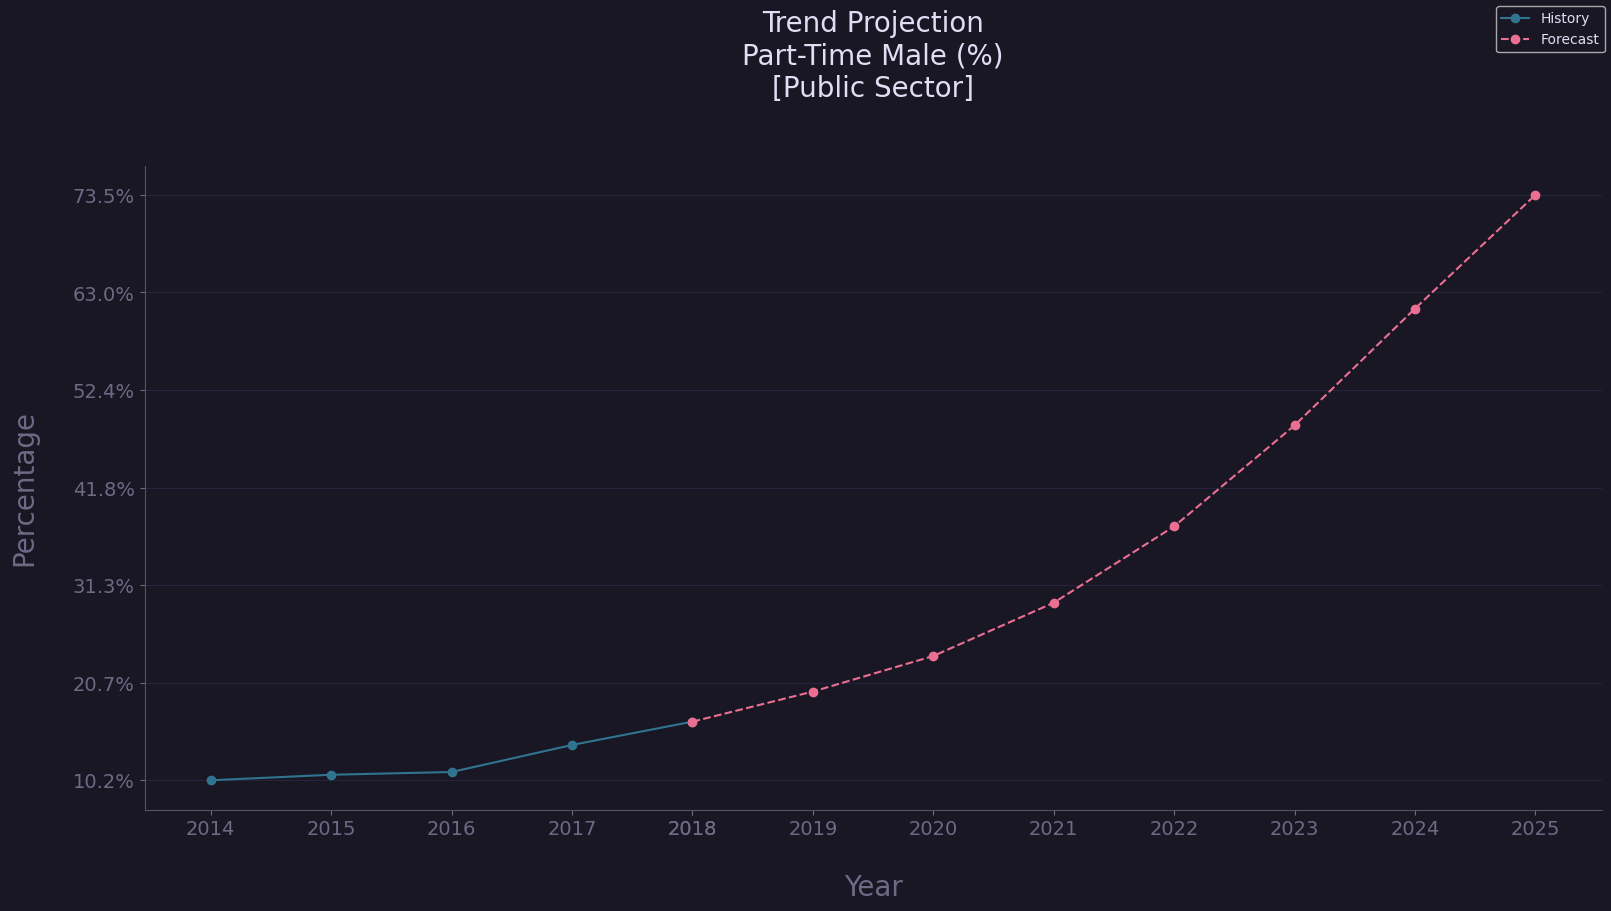

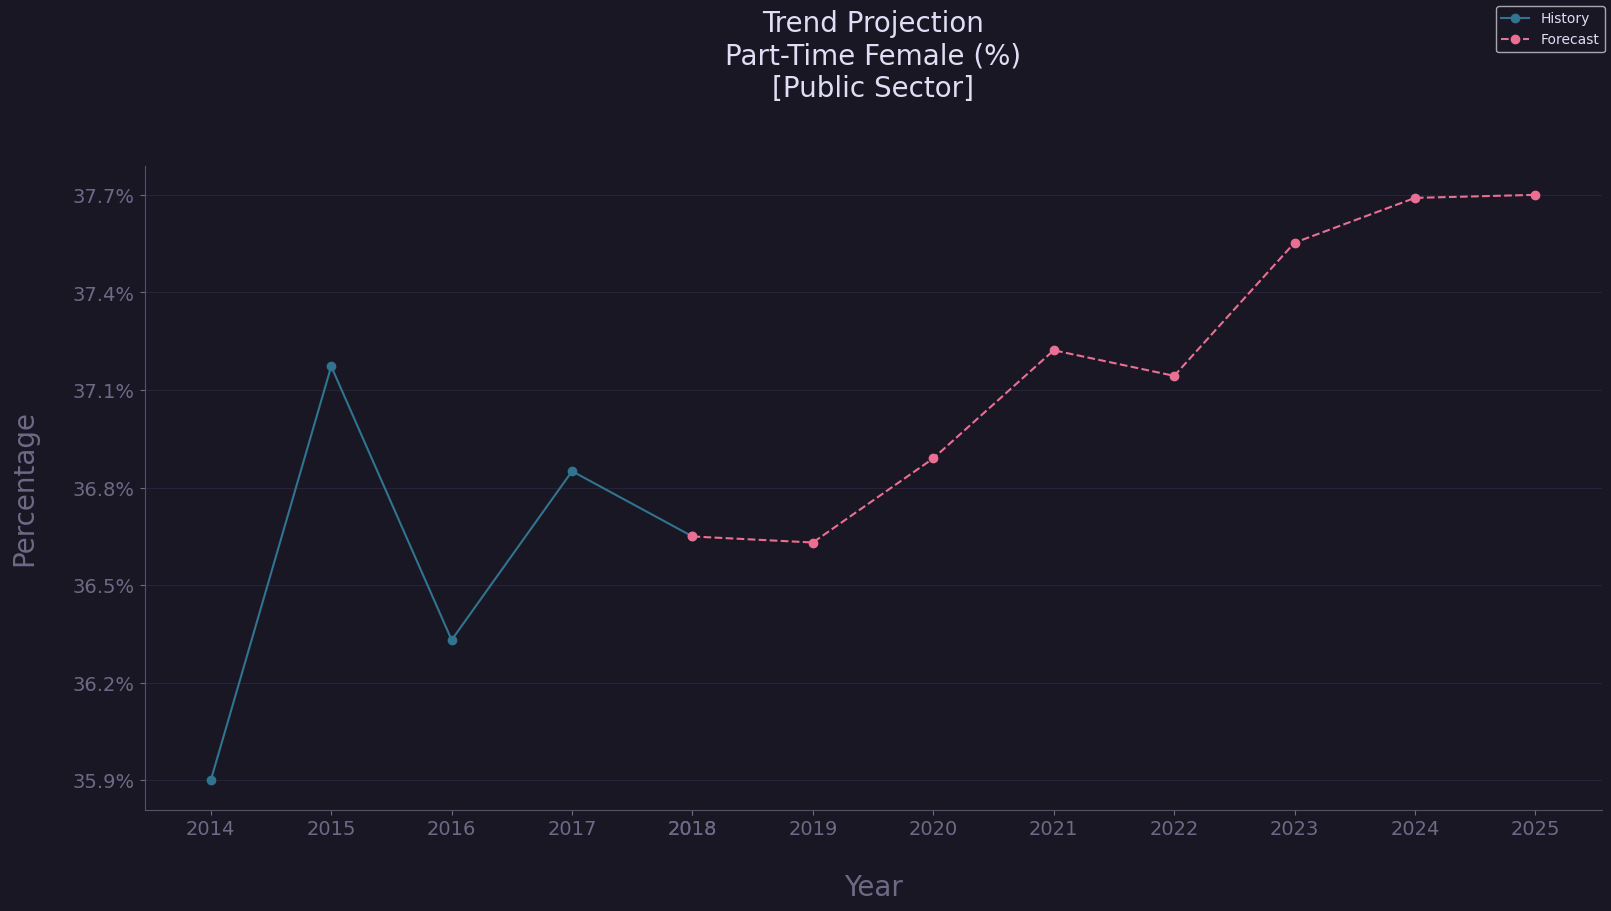

In [26]:
# Run here if already have forecast-agg.json

if os.path.isfile('forecast-direct.json'):
    with open('forecast-direct.json') as f:
        fc_direct = json.load(f)

if os.path.isfile('forecast-agg.json'):
    with open('forecast-agg.json') as f:
        fc_agg = json.load(f)

history_years = stats.index.to_list()
last_year = history_years[-1]

fc_direct = transpose(fc_direct)
pred_years = list(range(last_year+1, last_year+len(fc_direct)+1))
fc_direct['Year'] = np.array(pred_years)
fc_direct.set_index('Year', inplace=True)

fc_agg = transpose(fc_agg)
fc_agg['Year'] = np.array(pred_years)
fc_agg.set_index('Year', inplace=True)


for s in ['PT/Ratio', 'PT/M/Ratio', 'PT/F/Ratio'] :
    plot_trend(stats, fc_agg, 'Public Sector', s, show=True, save_fig=True, transparent=False)

In [27]:
# Part-Time Representation Change in the Public Sector
print('Public Sector PT (%) Change:', (fc_agg['Public Sector/PT/Ratio'].iloc[-1] - stats['Public Sector/PT/Ratio'].iloc[-1])*100)
print('Public Sector Male PT (%) Change:', (fc_agg['Public Sector/PT/M/Ratio'].iloc[-1] - stats['Public Sector/PT/M/Ratio'].iloc[-1])*100)
print('Public Sector Female PT (%) Change:', (fc_agg['Public Sector/PT/F/Ratio'].iloc[-1] - stats['Public Sector/PT/F/Ratio'].iloc[-1])*100)

Public Sector PT (%) Change: 28.626810837065424
Public Sector Male PT (%) Change: 57.01191494092064
Public Sector Female PT (%) Change: 1.011116865446865


In [28]:
# Part-Time Headcount Change in the Public Sector
print('Public Sector PT Change:', (fc_agg['Public Sector/PT'].iloc[-1] - stats['Public Sector/PT'].iloc[-1]))
print('Public Sector Male PT Change:', (fc_agg['Public Sector/PT/M'].iloc[-1] - stats['Public Sector/PT/M'].iloc[-1]))
print('Public Sector Female PT Change:', (fc_agg['Public Sector/PT/F'].iloc[-1] - stats['Public Sector/PT/F'].iloc[-1]))

Public Sector PT Change: 253729
Public Sector Male PT Change: 242719
Public Sector Female PT Change: 11010


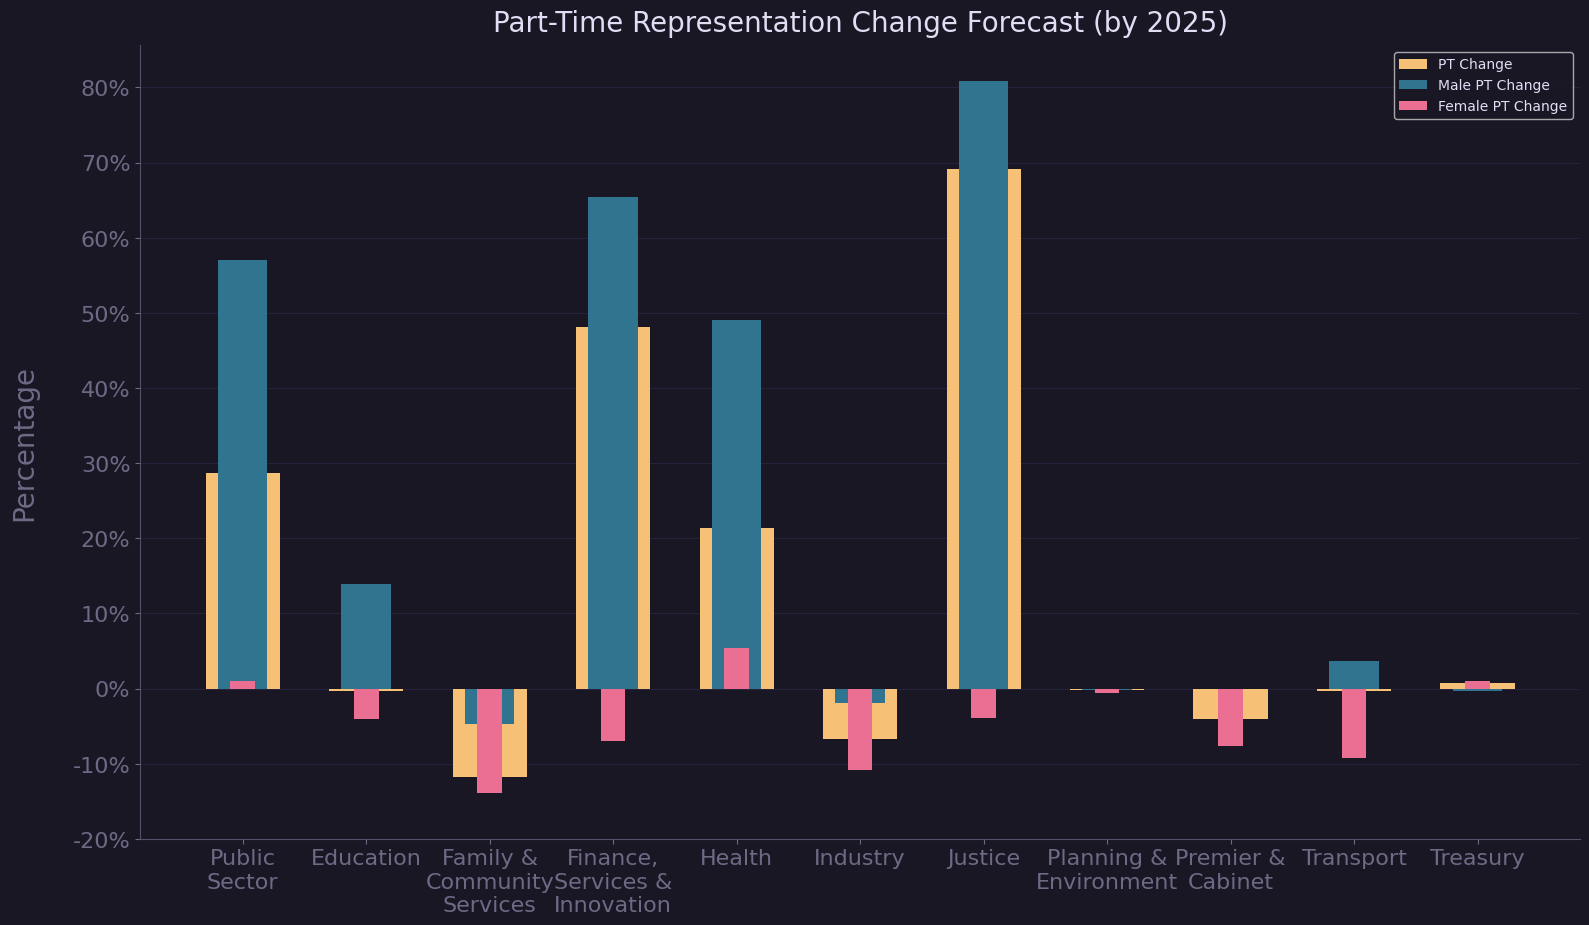

In [29]:
# Plot the forecasted change in Part-Time representation

if os.path.isfile('forecast-agg.json'):
    with open('forecast-agg.json') as f:
        fc_agg = json.load(f)
stats = statistics(df)

# Reminder: This function takes a dictionary, not the transpose dataframe.
plot_forecast_change(stats, fc_agg, save_fig=True, transparent=False)